In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import heapq
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from enum import Enum

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [236]:
class EventType(Enum):
    ARRIVAL = "arrival"
    SERVICE_COMPLETION = "service_completion"
    ABANDON = "abandon"
    CHARGING_COMPLETION = "charging_completion"

@dataclass
class Event:
    time: float
    event_type: EventType
    customer_id: Optional[int] = None
    server_id: Optional[int] = None
    
    def __lt__(self, other):
        return self.time < other.time

@dataclass
class Customer:
    id: int
    arrival_time: float
    service_time: float
    patience_time: float
    
    # Results to be filled during simulation
    queue_length_on_arrival: int = 0
    servers_available_on_arrival: int = 0
    servers_occupied_on_arrival: int = 0  # NEW: servers busy serving customers
    servers_charging_on_arrival: int = 0  # NEW: servers in charging state
    system_size_on_arrival: int = 0  # Total customers in system
    wait_time: float = 0.0
    service_start_time: float = 0.0
    departure_time: float = 0.0
    abandoned: bool = False

    def get_server_state_summary(self):
        """Get a summary of server states at arrival"""
        total = self.servers_available_on_arrival + self.servers_occupied_on_arrival + self.servers_charging_on_arrival
        return {
            'available': self.servers_available_on_arrival,
            'occupied': self.servers_occupied_on_arrival,
            'charging': self.servers_charging_on_arrival,
            'total': total
        }

class QueueSimulation:
    def __init__(self, num_customers: int, lambda_rate: float, mu_rate: float, 
                 theta_rate: float, num_servers: int, p_charge: float = 0.0, 
                 gamma_rate: float = 1.0, random_seed: int = 42):
        """
        Initialize queue simulation parameters
        
        Args:
            num_customers: Fixed number of customers to simulate
            lambda_rate: Arrival rate (λ)
            mu_rate: Service rate (μ)
            theta_rate: Abandonment rate (θ)
            num_servers: Total number of servers (c)
            p_charge: Probability of going to charge after service (p)
            gamma_rate: Charging completion rate (γ)
            random_seed: Random seed for reproducibility
        """
        self.num_customers = num_customers
        self.lambda_rate = lambda_rate
        self.mu_rate = mu_rate
        self.theta_rate = theta_rate
        self.num_servers = num_servers
        self.p_charge = p_charge
        self.gamma_rate = gamma_rate
        
        np.random.seed(random_seed)
        
        # Generate all random variables upfront
        self.customers = self._generate_customers()

        # Pre-generate charging decisions for server completions
        # We need more than num_customers because servers can complete multiple services
        max_service_completions = num_customers * 3  # Conservative estimate
        self.charging_decisions = np.random.binomial(1, self.p_charge, max_service_completions)
        #print(self.charging_decisions)
        self.charging_times = np.random.exponential(1/self.gamma_rate, max_service_completions)
        print(self.charging_times)
        self.charging_decision_index = 0
        
    def _generate_customers(self) -> List[Customer]:
        """Generate all customers with their random attributes"""
        customers = []
        
        # Generate inter-arrival times (exponential)
        inter_arrivals = np.random.exponential(1/self.lambda_rate, self.num_customers)
        arrival_times = np.cumsum(inter_arrivals)
        
        # Generate service times (exponential)
        service_times = np.random.exponential(1/self.mu_rate, self.num_customers)
        
        # Generate patience times (exponential)
        patience_times = np.random.exponential(1/self.theta_rate, self.num_customers)
        
        
        for i in range(self.num_customers):
            customer = Customer(
                id=i,
                arrival_time=arrival_times[i],
                service_time=service_times[i],
                patience_time=patience_times[i]
            )
            customers.append(customer)
            
        return customers
    
    def simulate_erlang_a(self) -> List[Customer]:
        """Simulate Erlang-A queue (no charging)"""
        # Initialize state
        event_queue = []
        queue = []  # Waiting customers
        servers = [None] * self.num_servers  # None means idle, customer_id means busy
        current_time = 0.0
        
        # Schedule all arrivals
        for customer in self.customers:
            heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
        
        # Process events
        while event_queue:
            event = heapq.heappop(event_queue)
            current_time = event.time
            
            if event.event_type == EventType.ARRIVAL:
                self._handle_arrival_erlang_a(event, queue, servers, event_queue)
            elif event.event_type == EventType.SERVICE_COMPLETION:
                self._handle_service_completion_erlang_a(event, queue, servers, event_queue)
            elif event.event_type == EventType.ABANDON:
                self._handle_abandon(event, queue)
        
        return self.customers
    
    def simulate_erlang_s(self) -> List[Customer]:
        """Simulate Erlang-S* queue (with charging)"""
        # Initialize state
        event_queue = []
        queue = []  # Waiting customers
        active_servers = list(range(self.num_servers))  # All servers start active
        charging_servers = []  # Servers in charging state
        server_assignments = {}  # server_id -> customer_id
        current_time = 0.0
        
        print(f"DEBUG: Starting simulation with {self.num_servers} servers")
        print(f"DEBUG: Initial active_servers: {active_servers}")
        
        # Schedule all arrivals
        for customer in self.customers:
            heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
        
        # Process events
        while event_queue:
            event = heapq.heappop(event_queue)
            current_time = event.time
            
            if event.event_type == EventType.ARRIVAL:
                self._handle_arrival_erlang_s(event, queue, active_servers, server_assignments, event_queue, charging_servers)
            elif event.event_type == EventType.SERVICE_COMPLETION:
                self._handle_service_completion_erlang_s(event, queue, active_servers, charging_servers, 
                                                    server_assignments, event_queue)
            elif event.event_type == EventType.ABANDON:
                self._handle_abandon(event, queue)
            elif event.event_type == EventType.CHARGING_COMPLETION:
                # Pass all necessary parameters for serving waiting customers
                self._handle_charging_completion(event, active_servers, charging_servers, 
                                            queue, server_assignments, event_queue)
        
        print(f"DEBUG: Final state - active: {len(active_servers)}, charging: {len(charging_servers)}, occupied: {len(server_assignments)}")
        return self.customers

    # Update the arrival handler to accept charging_servers
    def _handle_arrival_erlang_s(self, event, queue, active_servers, server_assignments, event_queue, charging_servers):
        customer = self.customers[event.customer_id]
        customer.queue_length_on_arrival = len(queue)
        
        # Track server states for Erlang-S*
        available_servers = len(active_servers)
        occupied_servers = len(server_assignments)
        charging_servers_count = len(charging_servers)
        
        customer.servers_available_on_arrival = available_servers
        customer.servers_occupied_on_arrival = occupied_servers
        customer.servers_charging_on_arrival = charging_servers_count
        
        # Verify server count consistency
        total_tracked = available_servers + occupied_servers + charging_servers_count
        if total_tracked != self.num_servers:
            print(f"DEBUG WARNING: Server count mismatch at time {event.time:.3f}")
            print(f"  Available: {available_servers}, Occupied: {occupied_servers}, Charging: {charging_servers_count}")
            print(f"  Total: {total_tracked}, Expected: {self.num_servers}")
        
        # Calculate total customers in system (queue + being served)
        customers_being_served = occupied_servers
        customer.system_size_on_arrival = len(queue) + customers_being_served
        
        if active_servers:
            # Start service immediately
            server_id = active_servers.pop(0)
            server_assignments[server_id] = customer.id
            customer.service_start_time = event.time
            customer.wait_time = 0.0
            
            # Schedule service completion
            completion_time = event.time + customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            customer.id, server_id))
        else:
            # Join queue and schedule abandonment
            queue.append(customer.id)
            abandon_time = event.time + customer.patience_time
            heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))
        
    def _handle_arrival_erlang_a(self, event, queue, servers, event_queue):
        customer = self.customers[event.customer_id]
        customer.queue_length_on_arrival = len(queue)
        
        # Track server states for Erlang-A
        available_servers = sum(1 for s in servers if s is None)
        occupied_servers = sum(1 for s in servers if s is not None)
        
        customer.servers_available_on_arrival = available_servers
        customer.servers_occupied_on_arrival = occupied_servers
        customer.servers_charging_on_arrival = 0  # No charging in Erlang-A
        
        # Calculate total customers in system (queue + being served)
        customers_being_served = occupied_servers
        customer.system_size_on_arrival = len(queue) + customers_being_served
        
        # Check if server is available
        available_server = None
        for i, server in enumerate(servers):
            if server is None:
                available_server = i
                break
        
        if available_server is not None:
            # Start service immediately
            servers[available_server] = customer.id
            customer.service_start_time = event.time
            customer.wait_time = 0.0
            
            # Schedule service completion
            completion_time = event.time + customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            customer.id, available_server))
        else:
            # Join queue and schedule abandonment
            queue.append(customer.id)
            abandon_time = event.time + customer.patience_time
            heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))

    # def _handle_arrival_erlang_s(self, event, queue, active_servers, server_assignments, event_queue):
    #     customer = self.customers[event.customer_id]
    #     customer.queue_length_on_arrival = len(queue)
        
    #     # Track server states for Erlang-S*
    #     # Note: we need to pass charging_servers to this method or track it differently
    #     # For now, we'll calculate it as total - active - occupied
    #     available_servers = len(active_servers)
    #     occupied_servers = len(server_assignments)
    #     charging_servers = self.num_servers - available_servers - occupied_servers
        
    #     customer.servers_available_on_arrival = available_servers
    #     customer.servers_occupied_on_arrival = occupied_servers
    #     customer.servers_charging_on_arrival = charging_servers
        
    #     # Calculate total customers in system (queue + being served)
    #     customers_being_served = occupied_servers
    #     customer.system_size_on_arrival = len(queue) + customers_being_served
        
    #     if active_servers:
    #         # Start service immediately
    #         server_id = active_servers.pop(0)
    #         server_assignments[server_id] = customer.id
    #         customer.service_start_time = event.time
    #         customer.wait_time = 0.0
            
    #         # Schedule service completion
    #         completion_time = event.time + customer.service_time
    #         heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
    #                                         customer.id, server_id))
    #     else:
    #         # Join queue and schedule abandonment
    #         queue.append(customer.id)
    #         abandon_time = event.time + customer.patience_time
    #         heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))

    def _handle_charging_completion(self, event, active_servers, charging_servers, queue=None, server_assignments=None, event_queue=None):
        """Handle server charging completion - move server back to active and serve waiting customers"""
        server_id = event.server_id
        if server_id in charging_servers:
            charging_servers.remove(server_id)
            
            # Check if there are waiting customers in queue
            if queue and len(queue) > 0 and server_assignments is not None and event_queue is not None:
                # Immediately serve next customer instead of going to active list
                next_customer_id = queue.pop(0)
                next_customer = self.customers[next_customer_id]
                
                # Assign server to customer
                server_assignments[server_id] = next_customer_id
                next_customer.service_start_time = event.time
                next_customer.wait_time = event.time - next_customer.arrival_time
                
                # Schedule service completion
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, server_id))
                
                print(f"DEBUG: Server {server_id} finished charging at time {event.time:.3f} and immediately serves customer {next_customer_id}")
            else:
                # No waiting customers, add to active servers
                active_servers.append(server_id)
                print(f"DEBUG: Server {server_id} finished charging at time {event.time:.3f} and becomes available")
            
            print(f"DEBUG: Active servers now: {active_servers}")
            print(f"DEBUG: Charging servers now: {charging_servers}")
        else:
            print(f"DEBUG: ERROR - Server {server_id} not found in charging_servers at time {event.time:.3f}")
            print(f"DEBUG: Current charging_servers: {charging_servers}")
            print(f"DEBUG: Current active_servers: {active_servers}")

    
    def _handle_service_completion_erlang_a(self, event, queue, servers, event_queue):
        customer = self.customers[event.customer_id]
        customer.departure_time = event.time
        servers[event.server_id] = None
        
        # Check if there's a waiting customer
        if queue:
            next_customer_id = queue.pop(0)
            next_customer = self.customers[next_customer_id]
            
            # Remove abandonment event for this customer (if it exists)
            # Note: In a more sophisticated implementation, we'd track and remove the event
            
            # Start service for next customer
            servers[event.server_id] = next_customer_id
            next_customer.service_start_time = event.time
            next_customer.wait_time = event.time - next_customer.arrival_time
            
            # Schedule service completion
            completion_time = event.time + next_customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            next_customer_id, event.server_id))
    
    def _handle_service_completion_erlang_s(self, event, queue, active_servers, charging_servers, server_assignments, event_queue):
        """Handle service completion in Erlang-S* system"""
        customer = self.customers[event.customer_id]
        customer.departure_time = event.time
        
        # Remove server from assignments
        if event.server_id in server_assignments:
            del server_assignments[event.server_id]
        else:
            print(f"DEBUG: WARNING - Server {event.server_id} not found in assignments")
        
        print(f"DEBUG: Service completion for customer {customer.id} by server {event.server_id} at time {event.time:.3f}")
        print(f"DEBUG: Queue length: {len(queue)}")
        
        # EVERY service completion should have a charging decision
        if self.charging_decision_index < len(self.charging_decisions):
            server_goes_to_charge = bool(self.charging_decisions[self.charging_decision_index])
            server_charging_time = self.charging_times[self.charging_decision_index]
            self.charging_decision_index += 1
            
            print(f"DEBUG: Server {event.server_id} charging decision: {server_goes_to_charge}")
            
            if server_goes_to_charge:
                # Server goes to charging regardless of queue status
                charging_servers.append(event.server_id)
                print(f"DEBUG: Server {event.server_id} starts charging for {server_charging_time:.3f} time units")
                
                # Schedule charging completion
                charging_completion_time = event.time + server_charging_time
                heapq.heappush(event_queue, Event(charging_completion_time, EventType.CHARGING_COMPLETION, 
                                                None, event.server_id))
                print(f"DEBUG: Charging completion scheduled for time {charging_completion_time:.3f}")
                
                # If there are waiting customers, they wait for this server to finish charging
                # OR other available servers can serve them
                
            else:
                # Server doesn't go charging, check if there are waiting customers
                if queue:
                    next_customer_id = queue.pop(0)
                    next_customer = self.customers[next_customer_id]
                    
                    # Use the same server that just finished
                    server_assignments[event.server_id] = next_customer_id
                    next_customer.service_start_time = event.time
                    next_customer.wait_time = event.time - next_customer.arrival_time
                    
                    print(f"DEBUG: Server {event.server_id} immediately serves next customer {next_customer_id}")
                    
                    # Schedule service completion
                    completion_time = event.time + next_customer.service_time
                    heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                    next_customer_id, event.server_id))
                else:
                    # No waiting customers, server becomes available
                    active_servers.append(event.server_id)
                    print(f"DEBUG: Server {event.server_id} becomes immediately available")
        else:
            # Fallback if we run out of pre-generated decisions
            if queue:
                next_customer_id = queue.pop(0)
                next_customer = self.customers[next_customer_id]
                server_assignments[event.server_id] = next_customer_id
                next_customer.service_start_time = event.time
                next_customer.wait_time = event.time - next_customer.arrival_time
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, event.server_id))
            else:
                active_servers.append(event.server_id)
                print(f"DEBUG: Server {event.server_id} becomes available (no more charging decisions)")
        
        print(f"DEBUG: After service completion - Active: {len(active_servers)}, Charging: {len(charging_servers)}, Occupied: {len(server_assignments)}")
        
    def _handle_abandon(self, event, queue):
        customer_id = event.customer_id
        if customer_id in queue:
            queue.remove(customer_id)
            customer = self.customers[customer_id]
            customer.abandoned = True
            customer.departure_time = event.time
    
    # def _handle_charging_completion(self, event, active_servers, charging_servers):
    #     server_id = event.server_id
    #     if server_id in charging_servers:
    #         charging_servers.remove(server_id)
    #         active_servers.append(server_id)


In [210]:
def analyze_and_visualize(customers_a: List[Customer], customers_s: List[Customer], 
                         params: Dict, save_plots: bool = False):
    """Analyze simulation results and create visualizations"""
    
    # Create DataFrames for analysis
    df_a = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-A'
    } for c in customers_a])
    
    df_s = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-S*'
    } for c in customers_s])
    
    df_combined = pd.concat([df_a, df_s], ignore_index=True)
    
    # Print summary statistics
    print("=== SIMULATION RESULTS ===")
    print(f"Parameters: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}")
    print(f"Erlang-S* specific: p={params['p']}, γ={params['gamma']}")
    print("\nERLANG-A QUEUE:")
    print(f"  Average wait time: {df_a['wait_time'].mean():.3f}")
    print(f"  Average queue length on arrival: {df_a['queue_length_on_arrival'].mean():.3f}")
    print(f"  Abandonment rate: {df_a['abandoned'].mean():.3f}")
    print(f"  Average servers available on arrival: {df_a['servers_available_on_arrival'].mean():.3f}")
    
    print("\nERLANG-S* QUEUE:")
    print(f"  Average wait time: {df_s['wait_time'].mean():.3f}")
    print(f"  Average queue length on arrival: {df_s['queue_length_on_arrival'].mean():.3f}")
    print(f"  Abandonment rate: {df_s['abandoned'].mean():.3f}")
    print(f"  Average servers available on arrival: {df_s['servers_available_on_arrival'].mean():.3f}")
    
    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Wait Time Distributions
    plt.subplot(3, 4, 1)
    non_abandoned_a = df_a[~df_a['abandoned']]['wait_time']
    non_abandoned_s = df_s[~df_s['abandoned']]['wait_time']
    
    plt.hist(non_abandoned_a, alpha=0.7, bins=30, label='Erlang-A', density=True)
    plt.hist(non_abandoned_s, alpha=0.7, bins=30, label='Erlang-S*', density=True)
    plt.xlabel('Wait Time')
    plt.ylabel('Density')
    plt.title('Wait Time Distribution\n(Non-abandoned customers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Queue Length on Arrival
    plt.subplot(3, 4, 2)
    queue_lengths_a = df_a['queue_length_on_arrival'].value_counts().sort_index()
    queue_lengths_s = df_s['queue_length_on_arrival'].value_counts().sort_index()
    
    x_pos = np.arange(max(queue_lengths_a.index.max(), queue_lengths_s.index.max()) + 1)
    plt.bar(x_pos - 0.2, [queue_lengths_a.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-A')
    plt.bar(x_pos + 0.2, [queue_lengths_s.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-S*')
    plt.xlabel('Queue Length on Arrival')
    plt.ylabel('Frequency')
    plt.title('Queue Length Distribution\n(On Arrival)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Servers Available on Arrival
    plt.subplot(3, 4, 3)
    servers_a = df_a['servers_available_on_arrival'].value_counts().sort_index()
    servers_s = df_s['servers_available_on_arrival'].value_counts().sort_index()
    
    x_pos = np.arange(params['c'] + 1)
    plt.bar(x_pos - 0.2, [servers_a.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-A')
    plt.bar(x_pos + 0.2, [servers_s.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-S*')
    plt.xlabel('Servers Available on Arrival')
    plt.ylabel('Frequency')
    plt.title('Available Servers Distribution\n(On Arrival)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Abandonment Comparison
    plt.subplot(3, 4, 4)
    abandon_rates = [df_a['abandoned'].mean(), df_s['abandoned'].mean()]
    systems = ['Erlang-A', 'Erlang-S*']
    colors = ['#1f77b4', '#ff7f0e']
    
    bars = plt.bar(systems, abandon_rates, color=colors, alpha=0.7)
    plt.ylabel('Abandonment Rate')
    plt.title('Abandonment Rate Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, abandon_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{rate:.3f}', ha='center', va='bottom')
    
    # 5. Wait Time Over Time
    plt.subplot(3, 4, 5)
    window_size = max(50, len(customers_a) // 20)
    df_a_sorted = df_a.sort_values('arrival_time')
    df_s_sorted = df_s.sort_values('arrival_time')
    
    wait_time_ma_a = df_a_sorted['wait_time'].rolling(window=window_size, center=True).mean()
    wait_time_ma_s = df_s_sorted['wait_time'].rolling(window=window_size, center=True).mean()
    
    plt.plot(df_a_sorted['arrival_time'], wait_time_ma_a, label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], wait_time_ma_s, label='Erlang-S*', alpha=0.8)
    plt.xlabel('Arrival Time')
    plt.ylabel('Wait Time (Moving Average)')
    plt.title(f'Wait Time Evolution\n(Moving Average, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Service Time vs Wait Time Scatter
    plt.subplot(3, 4, 6)
    non_abandoned_a = df_a[~df_a['abandoned']]
    non_abandoned_s = df_s[~df_s['abandoned']]
    
    plt.scatter(non_abandoned_a['service_time'], non_abandoned_a['wait_time'], 
               alpha=0.5, label='Erlang-A', s=20)
    plt.scatter(non_abandoned_s['service_time'], non_abandoned_s['wait_time'], 
               alpha=0.5, label='Erlang-S*', s=20)
    plt.xlabel('Service Time')
    plt.ylabel('Wait Time')
    plt.title('Service Time vs Wait Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Queue Length Evolution
    plt.subplot(3, 4, 7)
    plt.plot(df_a_sorted['arrival_time'], 
             df_a_sorted['queue_length_on_arrival'].rolling(window=window_size, center=True).mean(),
             label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], 
             df_s_sorted['queue_length_on_arrival'].rolling(window=window_size, center=True).mean(),
             label='Erlang-S*', alpha=0.8)
    plt.xlabel('Arrival Time')
    plt.ylabel('Queue Length (Moving Average)')
    plt.title(f'Queue Length Evolution\n(Moving Average, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Wait Time Box Plot
    plt.subplot(3, 4, 8)
    wait_data = [non_abandoned_a['wait_time'], non_abandoned_s['wait_time']]
    plt.boxplot(wait_data, labels=['Erlang-A', 'Erlang-S*'])
    plt.ylabel('Wait Time')
    plt.title('Wait Time Distribution\n(Box Plot)')
    plt.grid(True, alpha=0.3)
    
    # 9. Probability of Delay (P(Wait > 0))
    plt.subplot(3, 4, 9)
    delay_prob_a = (df_a['wait_time'] > 0).mean()
    delay_prob_s = (df_s['wait_time'] > 0).mean()
    
    bars = plt.bar(['Erlang-A', 'Erlang-S*'], [delay_prob_a, delay_prob_s], 
                   color=colors, alpha=0.7)
    plt.ylabel('Probability of Delay')
    plt.title('Probability of Delay\nP(Wait Time > 0)')
    plt.grid(True, alpha=0.3)
    
    for bar, prob in zip(bars, [delay_prob_a, delay_prob_s]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{prob:.3f}', ha='center', va='bottom')
    
    # 10. System Time Distribution (Wait + Service)
    plt.subplot(3, 4, 10)
    system_time_a = non_abandoned_a['wait_time'] + non_abandoned_a['service_time']
    system_time_s = non_abandoned_s['wait_time'] + non_abandoned_s['service_time']
    
    plt.hist(system_time_a, alpha=0.7, bins=30, label='Erlang-A', density=True)
    plt.hist(system_time_s, alpha=0.7, bins=30, label='Erlang-S*', density=True)
    plt.xlabel('System Time (Wait + Service)')
    plt.ylabel('Density')
    plt.title('System Time Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 11. Utilization Over Time (approximation)
    plt.subplot(3, 4, 11)
    busy_servers_a = params['c'] - df_a_sorted['servers_available_on_arrival']
    busy_servers_s = params['c'] - df_s_sorted['servers_available_on_arrival']
    
    utilization_a = busy_servers_a.rolling(window=window_size, center=True).mean() / params['c']
    utilization_s = busy_servers_s.rolling(window=window_size, center=True).mean() / params['c']
    
    plt.plot(df_a_sorted['arrival_time'], utilization_a, label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], utilization_s, label='Erlang-S*', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel('Utilization (approx)')
    plt.title('Server Utilization Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 12. Performance Metrics Summary
    plt.subplot(3, 4, 12)
    metrics = ['Avg Wait Time', 'Abandonment Rate', 'Delay Probability', 'Avg Queue Length']
    erlang_a_metrics = [
        df_a['wait_time'].mean(),
        df_a['abandoned'].mean(),
        delay_prob_a,
        df_a['queue_length_on_arrival'].mean()
    ]
    erlang_s_metrics = [
        df_s['wait_time'].mean(),
        df_s['abandoned'].mean(),
        delay_prob_s,
        df_s['queue_length_on_arrival'].mean()
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, erlang_a_metrics, width, label='Erlang-A', alpha=0.7)
    plt.bar(x + width/2, erlang_s_metrics, width, label='Erlang-S*', alpha=0.7)
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('queue_simulation_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return df_combined

In [211]:
def plot_queue_length_distribution(customers_a: List[Customer], customers_s: List[Customer], 
                                 params: Dict, save_plot: bool = False):
    """Create detailed plots comparing queue length distribution on arrival"""
    
    # Extract queue length data
    queue_lengths_a = [c.queue_length_on_arrival for c in customers_a]
    queue_lengths_s = [c.queue_length_on_arrival for c in customers_s]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Queue Length on Arrival Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Side-by-side bar chart (frequencies)
    ax1 = axes[0, 0]
    
    # Get value counts
    queue_counts_a = pd.Series(queue_lengths_a).value_counts().sort_index()
    queue_counts_s = pd.Series(queue_lengths_s).value_counts().sort_index()
    
    # Determine x-axis range
    max_queue = max(max(queue_lengths_a), max(queue_lengths_s))
    x_pos = np.arange(max_queue + 1)
    
    # Create bars
    width = 0.35
    bars_a = ax1.bar(x_pos - width/2, [queue_counts_a.get(i, 0) for i in x_pos], 
                     width, alpha=0.7, label='Erlang-A', color='#1f77b4')
    bars_s = ax1.bar(x_pos + width/2, [queue_counts_s.get(i, 0) for i in x_pos], 
                     width, alpha=0.7, label='Erlang-S*', color='#ff7f0e')
    
    ax1.set_xlabel('Queue Length on Arrival')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Queue Length Distribution (Frequencies)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(x_pos)
    
    # Add value labels on bars
    for i, (bar_a, bar_s) in enumerate(zip(bars_a, bars_s)):
        if bar_a.get_height() > 0:
            ax1.text(bar_a.get_x() + bar_a.get_width()/2, bar_a.get_height() + 5,
                    f'{int(bar_a.get_height())}', ha='center', va='bottom', fontsize=8)
        if bar_s.get_height() > 0:
            ax1.text(bar_s.get_x() + bar_s.get_width()/2, bar_s.get_height() + 5,
                    f'{int(bar_s.get_height())}', ha='center', va='bottom', fontsize=8)
    
    # 2. Probability mass function (normalized)
    ax2 = axes[0, 1]
    
    # Calculate probabilities
    prob_a = queue_counts_a / len(queue_lengths_a)
    prob_s = queue_counts_s / len(queue_lengths_s)
    
    bars_a = ax2.bar(x_pos - width/2, [prob_a.get(i, 0) for i in x_pos], 
                     width, alpha=0.7, label='Erlang-A', color='#1f77b4')
    bars_s = ax2.bar(x_pos + width/2, [prob_s.get(i, 0) for i in x_pos], 
                     width, alpha=0.7, label='Erlang-S*', color='#ff7f0e')
    
    ax2.set_xlabel('Queue Length on Arrival')
    ax2.set_ylabel('Probability')
    ax2.set_title('Queue Length Distribution (Probabilities)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(x_pos)
    
    # Add probability labels
    for i, (bar_a, bar_s) in enumerate(zip(bars_a, bars_s)):
        if bar_a.get_height() > 0:
            ax2.text(bar_a.get_x() + bar_a.get_width()/2, bar_a.get_height() + 0.005,
                    f'{bar_a.get_height():.3f}', ha='center', va='bottom', fontsize=8)
        if bar_s.get_height() > 0:
            ax2.text(bar_s.get_x() + bar_s.get_width()/2, bar_s.get_height() + 0.005,
                    f'{bar_s.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Cumulative distribution
    ax3 = axes[0, 2]
    
    # Calculate CDFs
    cdf_a = prob_a.cumsum()
    cdf_s = prob_s.cumsum()
    
    ax3.step(x_pos, [cdf_a.get(i, 0) for i in x_pos], where='post', 
             label='Erlang-A', alpha=0.8, linewidth=2)
    ax3.step(x_pos, [cdf_s.get(i, 0) for i in x_pos], where='post', 
             label='Erlang-S*', alpha=0.8, linewidth=2)
    
    ax3.set_xlabel('Queue Length on Arrival')
    ax3.set_ylabel('Cumulative Probability')
    ax3.set_title('Cumulative Distribution Function')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(x_pos)
    ax3.set_ylim(0, 1.05)
    
    # 4. Box plot comparison
    ax4 = axes[1, 0]
    
    box_data = [queue_lengths_a, queue_lengths_s]
    bp = ax4.boxplot(box_data, labels=['Erlang-A', 'Erlang-S*'], patch_artist=True)
    
    # Color the boxes
    colors = ['#1f77b4', '#ff7f0e']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('Queue Length on Arrival')
    ax4.set_title('Queue Length Distribution (Box Plot)')
    ax4.grid(True, alpha=0.3)
    
    # 5. Violin plot
    ax5 = axes[1, 1]
    
    # Create DataFrame for violin plot
    df_violin = pd.DataFrame({
        'Queue Length': queue_lengths_a + queue_lengths_s,
        'System': ['Erlang-A'] * len(queue_lengths_a) + ['Erlang-S*'] * len(queue_lengths_s)
    })
    
    parts = ax5.violinplot([queue_lengths_a, queue_lengths_s], positions=[1, 2], 
                          showmeans=True, showmedians=True, showextrema=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    ax5.set_xticks([1, 2])
    ax5.set_xticklabels(['Erlang-A', 'Erlang-S*'])
    ax5.set_ylabel('Queue Length on Arrival')
    ax5.set_title('Queue Length Distribution (Violin Plot)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Summary statistics table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Calculate statistics
    stats_a = {
        'Mean': np.mean(queue_lengths_a),
        'Median': np.median(queue_lengths_a),
        'Std Dev': np.std(queue_lengths_a),
        'Min': np.min(queue_lengths_a),
        'Max': np.max(queue_lengths_a),
        'P(Q=0)': (np.array(queue_lengths_a) == 0).mean(),
        'P(Q>0)': (np.array(queue_lengths_a) > 0).mean(),
        'P(Q≥5)': (np.array(queue_lengths_a) >= 5).mean()
    }
    
    stats_s = {
        'Mean': np.mean(queue_lengths_s),
        'Median': np.median(queue_lengths_s),
        'Std Dev': np.std(queue_lengths_s),
        'Min': np.min(queue_lengths_s),
        'Max': np.max(queue_lengths_s),
        'P(Q=0)': (np.array(queue_lengths_s) == 0).mean(),
        'P(Q>0)': (np.array(queue_lengths_s) > 0).mean(),
        'P(Q≥5)': (np.array(queue_lengths_s) >= 5).mean()
    }
    
    # Create table
    table_data = []
    for key in stats_a.keys():
        table_data.append([key, f"{stats_a[key]:.3f}", f"{stats_s[key]:.3f}"])
    
    table = ax6.table(cellText=table_data,
                     colLabels=['Statistic', 'Erlang-A', 'Erlang-S*'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color header
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color data rows alternately
    for i in range(1, len(table_data) + 1):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f1f1f2')
    
    ax6.set_title('Summary Statistics', fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig('queue_length_distribution_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print detailed comparison
    print("\n=== QUEUE LENGTH ON ARRIVAL ANALYSIS ===")
    print(f"Parameters: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}")
    print(f"Erlang-S* specific: p={params['p']}, γ={params['gamma']}")
    print("\nERLANG-A QUEUE:")
    for key, value in stats_a.items():
        print(f"  {key}: {value:.3f}")
    print("\nERLANG-S* QUEUE:")
    for key, value in stats_s.items():
        print(f"  {key}: {value:.3f}")
    
    print(f"\nDifference in means: {stats_s['Mean'] - stats_a['Mean']:.3f}")
    print(f"Ratio of means (S*/A): {stats_s['Mean'] / stats_a['Mean']:.3f}")
    
    return {
        'erlang_a_stats': stats_a,
        'erlang_s_stats': stats_s,
        'queue_lengths_a': queue_lengths_a,
        'queue_lengths_s': queue_lengths_s
    }

In [212]:
def plot_system_size_distribution(customers_a: List[Customer], customers_s: List[Customer], 
                                params: Dict, save_plot: bool = False):
    """Create detailed plots comparing system size distribution on arrival"""
    
    # Extract system size data
    system_sizes_a = [c.system_size_on_arrival for c in customers_a]
    system_sizes_s = [c.system_size_on_arrival for c in customers_s]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('System Size on Arrival Distribution Analysis\n(Total Customers in System = Queue + Being Served)', 
                 fontsize=16, fontweight='bold')
    
    # Get value counts and probabilities
    system_counts_a = pd.Series(system_sizes_a).value_counts().sort_index()
    system_counts_s = pd.Series(system_sizes_s).value_counts().sort_index()
    
    prob_a = system_counts_a / len(system_sizes_a)
    prob_s = system_counts_s / len(system_sizes_s)
    
    # Determine x-axis range - be smarter about this!
    max_system = max(max(system_sizes_a), max(system_sizes_s))
    mean_system = max(np.mean(system_sizes_a), np.mean(system_sizes_s))
    
    # Show up to 3 standard deviations or 99.9th percentile, whichever is smaller
    p99_9_a = np.percentile(system_sizes_a, 99.9)
    p99_9_s = np.percentile(system_sizes_s, 99.9)
    p99_9 = max(p99_9_a, p99_9_s)
    
    std_system = max(np.std(system_sizes_a), np.std(system_sizes_s))
    three_sigma_limit = int(mean_system + 3 * std_system)
    
    # Choose display range: show meaningful range but cap at reasonable limit
    display_max = min(max_system, int(p99_9), max(100, three_sigma_limit))
    x_pos = np.arange(display_max + 1)
    
    print(f"DEBUG: max_system={max_system}, mean={mean_system:.1f}, std={std_system:.1f}")
    print(f"DEBUG: p99.9={p99_9:.1f}, 3σ limit={three_sigma_limit}, display_max={display_max}")
    
    # 1. Erlang-A Probability Distribution
    ax1 = axes[0, 0]
    
    bars_a = ax1.bar(x_pos, [prob_a.get(i, 0) for i in x_pos], 
                     width=0.8, alpha=0.7, color='#1f77b4', edgecolor='darkblue', linewidth=0.5)
    
    ax1.set_xlabel('System Size on Arrival')
    ax1.set_ylabel('Probability')
    ax1.set_title('Erlang-A System Size Distribution', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add probability labels for significant bars (only first 20 to avoid clutter)
    for i, bar in enumerate(bars_a[:20]):
        if bar.get_height() > 0.01:  # Only label bars with probability > 1%
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                    f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    
    # Add mean line
    mean_a = np.mean(system_sizes_a)
    ax1.axvline(mean_a, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean = {mean_a:.2f}')
    ax1.legend()
    
    # Add text showing truncation info if needed
    if display_max < max_system:
        ax1.text(0.7, 0.9, f'Showing 0-{display_max}\nMax value: {max_system}', 
                transform=ax1.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 2. Erlang-S* Probability Distribution
    ax2 = axes[0, 1]
    
    bars_s = ax2.bar(x_pos, [prob_s.get(i, 0) for i in x_pos], 
                     width=0.8, alpha=0.7, color='#ff7f0e', edgecolor='darkorange', linewidth=0.5)
    
    ax2.set_xlabel('System Size on Arrival')
    ax2.set_ylabel('Probability')
    ax2.set_title('Erlang-S* System Size Distribution', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add probability labels for significant bars (only first 20 to avoid clutter)
    for i, bar in enumerate(bars_s[:20]):
        if bar.get_height() > 0.01:  # Only label bars with probability > 1%
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                    f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    
    # Add mean line
    mean_s = np.mean(system_sizes_s)
    ax2.axvline(mean_s, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean = {mean_s:.2f}')
    ax2.legend()
    
    # Add text showing truncation info if needed
    if display_max < max_system:
        ax2.text(0.7, 0.9, f'Showing 0-{display_max}\nMax value: {max_system}', 
                transform=ax2.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 3. Comparison with theoretical Poisson
    ax3 = axes[0, 2]
    
    # Theoretical expectation: For M/M/∞ with abandonment, system size ~ Poisson(λ/μ)
    theoretical_mean = params['lambda'] / (params['mu'])
    
    # Plot theoretical Poisson - but adjust range if mean is very different
    if theoretical_mean < display_max:
        # Plot theoretical Poisson
        from scipy.stats import poisson
        theoretical_probs = [poisson.pmf(i, theoretical_mean) for i in x_pos]
        
        width = 0.25
        ax3.bar(x_pos - width, [prob_a.get(i, 0) for i in x_pos], 
                width, alpha=0.7, label='Erlang-A', color='#1f77b4')
        ax3.bar(x_pos, [prob_s.get(i, 0) for i in x_pos], 
                width, alpha=0.7, label='Erlang-S*', color='#ff7f0e')
        ax3.plot(x_pos, theoretical_probs, 'ro-', alpha=0.8, 
                 label=f'Poisson({theoretical_mean:.2f})', markersize=4)
        
        ax3.set_xlabel('System Size on Arrival')
        ax3.set_ylabel('Probability')
        ax3.set_title(f'Comparison with Theoretical\nPoisson(λ/μ={theoretical_mean:.2f})')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        # If theoretical mean is way off, show a message
        ax3.text(0.5, 0.5, f'Theoretical mean ({theoretical_mean:.1f}) is\nmuch larger than display range\n(0-{display_max})\n\nCheck simulation parameters!', 
                ha='center', va='center', transform=ax3.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7, color='white'),
                fontsize=12, fontweight='bold')
        ax3.set_title('Theoretical Comparison\n(Out of Range!)')
    
    # 4. Box plot comparison
    ax4 = axes[1, 0]
    
    box_data = [system_sizes_a, system_sizes_s]
    bp = ax4.boxplot(box_data, labels=['Erlang-A', 'Erlang-S*'], patch_artist=True)
    
    # Color the boxes
    colors = ['#1f77b4', '#ff7f0e']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('System Size on Arrival')
    ax4.set_title('System Size Distribution (Box Plot)')
    ax4.grid(True, alpha=0.3)
    
    # 5. Cumulative distribution
    ax5 = axes[1, 1]
    
    # Calculate CDFs
    cdf_a = prob_a.cumsum()
    cdf_s = prob_s.cumsum()
    
    ax5.step(x_pos, [cdf_a.get(i, 0) for i in x_pos], where='post', 
             label='Erlang-A', alpha=0.8, linewidth=2, color='#1f77b4')
    ax5.step(x_pos, [cdf_s.get(i, 0) for i in x_pos], where='post', 
             label='Erlang-S*', alpha=0.8, linewidth=2, color='#ff7f0e')
    
    # Theoretical CDF (if in range)
    if theoretical_mean < display_max:
        from scipy.stats import poisson
        theoretical_cdf = [poisson.cdf(i, theoretical_mean) for i in x_pos]
        ax5.plot(x_pos, theoretical_cdf, 'r--', alpha=0.8, 
                 label=f'Poisson({theoretical_mean:.2f})', linewidth=2)
    
    ax5.set_xlabel('System Size on Arrival')
    ax5.set_ylabel('Cumulative Probability')
    ax5.set_title('Cumulative Distribution Function')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(0, 1.05)
    
    # Show percentage of data captured in display range
    pct_captured_a = (np.array(system_sizes_a) <= display_max).mean() * 100
    pct_captured_s = (np.array(system_sizes_s) <= display_max).mean() * 100
    ax5.text(0.6, 0.2, f'Data shown:\nErlang-A: {pct_captured_a:.1f}%\nErlang-S*: {pct_captured_s:.1f}%', 
             transform=ax5.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    # 6. Summary statistics table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Calculate statistics
    stats_a = {
        'Mean': np.mean(system_sizes_a),
        'Median': np.median(system_sizes_a),
        'Std Dev': np.std(system_sizes_a),
        'Min': np.min(system_sizes_a),
        'Max': np.max(system_sizes_a),
        'P(N=0)': (np.array(system_sizes_a) == 0).mean(),
        'P(N>0)': (np.array(system_sizes_a) > 0).mean(),
        'P(N≥10)': (np.array(system_sizes_a) >= 10).mean()
    }
    
    stats_s = {
        'Mean': np.mean(system_sizes_s),
        'Median': np.median(system_sizes_s),
        'Std Dev': np.std(system_sizes_s),
        'Min': np.min(system_sizes_s),
        'Max': np.max(system_sizes_s),
        'P(N=0)': (np.array(system_sizes_s) == 0).mean(),
        'P(N>0)': (np.array(system_sizes_s) > 0).mean(),
        'P(N≥10)': (np.array(system_sizes_s) >= 10).mean()
    }
    
    # Add theoretical statistics
    theoretical_stats = {
        'Mean': theoretical_mean,
        'Median': poisson.median(theoretical_mean) if 'poisson' in locals() else 'N/A',
        'Std Dev': np.sqrt(theoretical_mean),
        'Min': 0,
        'Max': '∞',
        'P(N=0)': poisson.pmf(0, theoretical_mean) if 'poisson' in locals() else 'N/A',
        'P(N>0)': 1 - poisson.pmf(0, theoretical_mean) if 'poisson' in locals() else 'N/A',
        'P(N≥10)': 1 - poisson.cdf(9, theoretical_mean) if 'poisson' in locals() else 'N/A'
    }
    
    # Create table
    table_data = []
    for key in stats_a.keys():
        theo_val = theoretical_stats[key]
        if isinstance(theo_val, (int, float)):
            theo_str = f"{theo_val:.3f}"
        else:
            theo_str = str(theo_val)
        table_data.append([key, f"{stats_a[key]:.3f}", f"{stats_s[key]:.3f}", theo_str])
    
    table = ax6.table(cellText=table_data,
                     colLabels=['Statistic', 'Erlang-A', 'Erlang-S*', 'Theory'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Color header
    for i in range(4):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color data rows alternately
    for i in range(1, len(table_data) + 1):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f1f1f2')
    
    ax6.set_title('Summary Statistics\n(N = System Size)', fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig('system_size_distribution_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print detailed comparison with warnings
    print("\n=== SYSTEM SIZE ON ARRIVAL ANALYSIS ===")
    print(f"Parameters: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}")
    print(f"Theoretical mean (λ/μ): {theoretical_mean:.3f}")
    print(f"Erlang-S* specific: p={params['p']}, γ={params['gamma']}")
    
    # Check for potential issues
    if abs(stats_a['Mean'] - theoretical_mean) > theoretical_mean * 0.5:
        print(f"\n⚠️  WARNING: Observed mean ({stats_a['Mean']:.1f}) differs significantly from theory ({theoretical_mean:.1f})!")
        print("   This suggests either:")
        print("   1. Simulation hasn't reached steady state")
        print("   2. There's a bug in the simulation")
        print("   3. Parameters create an unstable system")
    
    print("\nERLANG-A SYSTEM:")
    for key, value in stats_a.items():
        print(f"  {key}: {value:.3f}")
    print("\nERLANG-S* SYSTEM:")
    for key, value in stats_s.items():
        print(f"  {key}: {value:.3f}")
    print("\nTHEORETICAL (Poisson):")
    for key, value in theoretical_stats.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.3f}")
        else:
            print(f"  {key}: {value}")
    
    print(f"\nDifference in means: {stats_s['Mean'] - stats_a['Mean']:.3f}")
    print(f"Ratio of means (S*/A): {stats_s['Mean'] / stats_a['Mean']:.3f}")
    print(f"Theory vs Erlang-A difference: {abs(stats_a['Mean'] - theoretical_mean):.3f}")
    print(f"Theory vs Erlang-S* difference: {abs(stats_s['Mean'] - theoretical_mean):.3f}")
    
    return {
        'erlang_a_stats': stats_a,
        'erlang_s_stats': stats_s,
        'theoretical_stats': theoretical_stats,
        'system_sizes_a': system_sizes_a,
        'system_sizes_s': system_sizes_s,
        'display_range': (0, display_max),
        'actual_range': (0, max_system)
    }

In [213]:
def analyze_server_states(customers_a: List[Customer], customers_s: List[Customer], 
                         params: Dict, save_plot: bool = False):
    """Analyze and visualize server state distributions"""
    
    print("\n=== SERVER STATE ANALYSIS ===")
    
    # Extract server state data
    def get_server_stats(customers, system_name):
        available = [c.servers_available_on_arrival for c in customers]
        occupied = [c.servers_occupied_on_arrival for c in customers]
        charging = [c.servers_charging_on_arrival for c in customers]
        
        stats = {
            'available_mean': np.mean(available),
            'available_std': np.std(available),
            'occupied_mean': np.mean(occupied),
            'occupied_std': np.std(occupied),
            'charging_mean': np.mean(charging),
            'charging_std': np.std(charging),
            'utilization': np.mean(occupied) / params['c'],  # Fraction of servers busy
            'charging_rate': np.mean(charging) / params['c']  # Fraction of servers charging
        }
        
        print(f"\n{system_name} SERVER STATES:")
        print(f"  Average available: {stats['available_mean']:.2f} ± {stats['available_std']:.2f}")
        print(f"  Average occupied:  {stats['occupied_mean']:.2f} ± {stats['occupied_std']:.2f}")
        print(f"  Average charging:  {stats['charging_mean']:.2f} ± {stats['charging_std']:.2f}")
        print(f"  Server utilization: {stats['utilization']:.3f} ({stats['utilization']*100:.1f}%)")
        print(f"  Charging rate: {stats['charging_rate']:.3f} ({stats['charging_rate']*100:.1f}%)")
        
        return stats, available, occupied, charging
    
    stats_a, avail_a, occ_a, charg_a = get_server_stats(customers_a, "ERLANG-A")
    stats_s, avail_s, occ_s, charg_s = get_server_stats(customers_s, "ERLANG-S*")
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Server State Analysis on Customer Arrival', fontsize=16, fontweight='bold')
    
    # 1. Server state distribution - Erlang-A
    ax1 = axes[0, 0]
    server_states_a = np.array([avail_a, occ_a, charg_a])
    
    x_pos = np.arange(len(customers_a))
    ax1.bar(x_pos, avail_a, label='Available', alpha=0.7, color='green')
    ax1.bar(x_pos, occ_a, bottom=avail_a, label='Occupied', alpha=0.7, color='red')
    # Note: charging is always 0 for Erlang-A, so no need to stack it
    
    ax1.set_xlabel('Customer Arrival Order')
    ax1.set_ylabel('Number of Servers')
    ax1.set_title('Erlang-A: Server States Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Server state distribution - Erlang-S*
    ax2 = axes[0, 1]
    
    x_pos = np.arange(len(customers_s))
    ax2.bar(x_pos, avail_s, label='Available', alpha=0.7, color='green')
    ax2.bar(x_pos, occ_s, bottom=avail_s, label='Occupied', alpha=0.7, color='red')
    ax2.bar(x_pos, charg_s, bottom=np.array(avail_s) + np.array(occ_s), 
            label='Charging', alpha=0.7, color='orange')
    
    ax2.set_xlabel('Customer Arrival Order')
    ax2.set_ylabel('Number of Servers')
    ax2.set_title('Erlang-S*: Server States Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Average server state comparison
    ax3 = axes[0, 2]
    
    categories = ['Available', 'Occupied', 'Charging']
    erlang_a_means = [stats_a['available_mean'], stats_a['occupied_mean'], stats_a['charging_mean']]
    erlang_s_means = [stats_s['available_mean'], stats_s['occupied_mean'], stats_s['charging_mean']]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, erlang_a_means, width, label='Erlang-A', alpha=0.7)
    bars2 = ax3.bar(x + width/2, erlang_s_means, width, label='Erlang-S*', alpha=0.7)
    
    ax3.set_ylabel('Average Number of Servers')
    ax3.set_title('Average Server States Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Utilization over time
    ax4 = axes[1, 0]
    
    # Calculate utilization as moving average
    window_size = max(10, len(customers_a) // 10)
    util_a = pd.Series(occ_a).rolling(window=window_size, center=True).mean() / params['c']
    util_s = pd.Series(occ_s).rolling(window=window_size, center=True).mean() / params['c']
    
    arrival_times_a = [c.arrival_time for c in customers_a]
    arrival_times_s = [c.arrival_time for c in customers_s]
    
    ax4.plot(arrival_times_a, util_a, label='Erlang-A', alpha=0.8, linewidth=2)
    ax4.plot(arrival_times_s, util_s, label='Erlang-S*', alpha=0.8, linewidth=2)
    
    ax4.set_xlabel('Arrival Time')
    ax4.set_ylabel('Server Utilization')
    ax4.set_title(f'Server Utilization Over Time (window={window_size})')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1)
    
    # 5. Server state histograms for Erlang-S*
    ax5 = axes[1, 1]
    
    bins = np.arange(params['c'] + 2) - 0.5
    ax5.hist(avail_s, bins=bins, alpha=0.7, label='Available', color='green', density=True)
    ax5.hist(occ_s, bins=bins, alpha=0.7, label='Occupied', color='red', density=True)
    ax5.hist(charg_s, bins=bins, alpha=0.7, label='Charging', color='orange', density=True)
    
    ax5.set_xlabel('Number of Servers')
    ax5.set_ylabel('Density')
    ax5.set_title('Erlang-S*: Server State Distributions')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xticks(range(params['c'] + 1))
    
    # 6. Performance metrics table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Create comparison table
    table_data = [
        ['Metric', 'Erlang-A', 'Erlang-S*', 'Difference'],
        ['Avg Available', f"{stats_a['available_mean']:.2f}", f"{stats_s['available_mean']:.2f}", 
         f"{stats_s['available_mean'] - stats_a['available_mean']:.2f}"],
        ['Avg Occupied', f"{stats_a['occupied_mean']:.2f}", f"{stats_s['occupied_mean']:.2f}",
         f"{stats_s['occupied_mean'] - stats_a['occupied_mean']:.2f}"],
        ['Avg Charging', f"{stats_a['charging_mean']:.2f}", f"{stats_s['charging_mean']:.2f}",
         f"{stats_s['charging_mean'] - stats_a['charging_mean']:.2f}"],
        ['Utilization', f"{stats_a['utilization']:.3f}", f"{stats_s['utilization']:.3f}",
         f"{stats_s['utilization'] - stats_a['utilization']:.3f}"],
        ['Charging Rate', f"{stats_a['charging_rate']:.3f}", f"{stats_s['charging_rate']:.3f}",
         f"{stats_s['charging_rate'] - stats_a['charging_rate']:.3f}"]
    ]
    
    table = ax6.table(cellText=table_data[1:],
                     colLabels=table_data[0],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color header
    for i in range(4):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color data rows alternately
    for i in range(1, len(table_data)):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f1f1f2')
    
    ax6.set_title('Server State Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig('server_state_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Check for issues
    print(f"\n=== SERVER STATE DIAGNOSTICS ===")
    if stats_s['charging_mean'] == 0 and params['p'] > 0:
        print("⚠️  WARNING: No servers are charging despite p > 0!")
        print("   This suggests the charging mechanism isn't working properly.")
    elif stats_s['charging_mean'] < params['p'] * stats_s['occupied_mean'] * 0.5:
        print("⚠️  WARNING: Charging rate seems low relative to expected value")
        print(f"   Expected charging ≈ p × service_rate = {params['p']} × service_rate")
    else:
        print("✅ Charging mechanism appears to be working")
    
    return {
        'stats_a': stats_a,
        'stats_s': stats_s,
        'server_states_a': (avail_a, occ_a, charg_a),
        'server_states_s': (avail_s, occ_s, charg_s)
    }

In [214]:
def print_customer_server_details(customers: List[Customer], system_name: str, max_customers: int = 10):
    """Print detailed server state information for each customer"""
    
    print(f"\n=== {system_name} DETAILED CUSTOMER SERVER STATES ===")
    print(f"Showing first {min(max_customers, len(customers))} customers:")
    print()
    print(f"{'ID':<3} {'Arrival':<8} {'Queue':<5} {'Available':<9} {'Occupied':<8} {'Charging':<8} {'Total':<5} {'Wait':<6} {'Abandoned':<9}")
    print("-" * 75)
    
    for i, customer in enumerate(customers[:max_customers]):
        server_state = customer.get_server_state_summary()
        print(f"{customer.id:<3} {customer.arrival_time:<8.2f} {customer.queue_length_on_arrival:<5} "
              f"{server_state['available']:<9} {server_state['occupied']:<8} {server_state['charging']:<8} "
              f"{server_state['total']:<5} {customer.wait_time:<6.2f} {str(customer.abandoned):<9}")
    
    if len(customers) > max_customers:
        print(f"... ({len(customers) - max_customers} more customers)")
    
    # Summary statistics
    all_states = [c.get_server_state_summary() for c in customers]
    avg_available = np.mean([s['available'] for s in all_states])
    avg_occupied = np.mean([s['occupied'] for s in all_states])
    avg_charging = np.mean([s['charging'] for s in all_states])
    
    print(f"\nSummary for {system_name}:")
    print(f"  Average servers available: {avg_available:.2f}")
    print(f"  Average servers occupied:  {avg_occupied:.2f}")
    print(f"  Average servers charging:  {avg_charging:.2f}")
    print(f"  Total servers: {all_states[0]['total'] if all_states else 'N/A'}")

In [215]:
def print_simulation_events(customers_s, params):
    """Print a detailed trace of simulation events to debug charging"""
    
    print("\n" + "="*80)
    print("DETAILED SIMULATION EVENT TRACE")
    print("="*80)
    
    # Re-run simulation with detailed logging
    sim_debug = QueueSimulation(
        num_customers=len(customers_s),
        lambda_rate=params['lambda'],
        mu_rate=params['mu'],
        theta_rate=params['theta'],
        num_servers=params['c'],
        p_charge=params['p'],
        gamma_rate=params['gamma'],
        random_seed=42  # Same seed for reproducibility
    )
    
    # Run with detailed event logging
    event_queue = []
    queue = []
    active_servers = list(range(sim_debug.num_servers))
    charging_servers = []
    server_assignments = {}
    current_time = 0.0
    
    print(f"Initial state: Active servers: {active_servers}")
    
    # Schedule all arrivals
    for customer in sim_debug.customers:
        heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
    
    event_count = 0
    # Process events with detailed logging
    while event_queue and event_count < 50:  # Limit to first 50 events for readability
        event = heapq.heappop(event_queue)
        current_time = event.time
        event_count += 1
        
        print(f"\n--- Event {event_count}: {event.event_type.value} at time {event.time:.3f} ---")
        
        # Process the event (simplified version for debugging)
        if event.event_type == EventType.ARRIVAL:
            customer = sim_debug.customers[event.customer_id]
            
            # CAPTURE SERVER STATES LIKE IN THE REAL SIMULATION
            available_servers = len(active_servers)
            occupied_servers = len(server_assignments)
            charging_servers_count = len(charging_servers)
            
            print(f"Customer {event.customer_id} arrives")
            print(f"  Server states on arrival: Available={available_servers}, Occupied={occupied_servers}, Charging={charging_servers_count}")
            
            if active_servers:
                server_id = active_servers.pop(0)
                server_assignments[server_id] = customer.id
                completion_time = event.time + customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                customer.id, server_id))
                print(f"  → Server {server_id} starts serving customer {customer.id}")
            else:
                queue.append(customer.id)
                print(f"  → Customer {customer.id} joins queue (length now {len(queue)})")
                
        elif event.event_type == EventType.SERVICE_COMPLETION:
            print(f"Customer {event.customer_id} completes service (server {event.server_id})")
            print(f"  Before completion: Active={len(active_servers)}, Charging={len(charging_servers)}, Occupied={len(server_assignments)}")
            
            if event.server_id in server_assignments:
                del server_assignments[event.server_id]
            
            # Check for waiting customers first
            if queue:
                next_customer_id = queue.pop(0)
                server_assignments[event.server_id] = next_customer_id
                next_customer = sim_debug.customers[next_customer_id]
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, event.server_id))
                print(f"  → Server {event.server_id} immediately serves next customer {next_customer_id}")
            else:
                # EVERY service completion should have a charging decision
                if sim_debug.charging_decision_index < len(sim_debug.charging_decisions):
                    goes_charging = bool(sim_debug.charging_decisions[sim_debug.charging_decision_index])
                    charge_time = sim_debug.charging_times[sim_debug.charging_decision_index]
                    sim_debug.charging_decision_index += 1
                    
                    print(f"  → Charging decision for server {event.server_id}: {goes_charging}")
                    
                    if goes_charging:
                        charging_servers.append(event.server_id)
                        charging_completion_time = event.time + charge_time
                        heapq.heappush(event_queue, Event(charging_completion_time, EventType.CHARGING_COMPLETION, 
                                                        None, event.server_id))
                        print(f"  → Server {event.server_id} starts charging for {charge_time:.3f} time units")
                        print(f"  → Charging completion scheduled for time {charging_completion_time:.3f}")
                    else:
                        active_servers.append(event.server_id)
                        print(f"  → Server {event.server_id} becomes immediately available")
                else:
                    active_servers.append(event.server_id)
                    print(f"  → Server {event.server_id} becomes available (no charging decisions left)")
                    
        elif event.event_type == EventType.CHARGING_COMPLETION:
            print(f"Server {event.server_id} completes charging")
            print(f"  Before charging completion: Active={len(active_servers)}, Charging={len(charging_servers)}")
            
            if event.server_id in charging_servers:
                charging_servers.remove(event.server_id)
                
                # Check if there are waiting customers
                if queue:
                    # Serve next customer immediately
                    next_customer_id = queue.pop(0)
                    server_assignments[event.server_id] = next_customer_id
                    next_customer = sim_debug.customers[next_customer_id]
                    completion_time = event.time + next_customer.service_time
                    heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                    next_customer_id, event.server_id))
                    print(f"  → Server {event.server_id} finished charging and immediately serves customer {next_customer_id}")
                else:
                    active_servers.append(event.server_id)
                    print(f"  → Server {event.server_id} finished charging, now available")
            else:
                print(f"  → ERROR: Server {event.server_id} not found in charging list!")
        
        print(f"  After event: Active={len(active_servers)}, Charging={len(charging_servers)}, Occupied={len(server_assignments)}")
        print(f"  Server states: Active={active_servers}, Charging={charging_servers}")
        
        # Verify total servers
        total = len(active_servers) + len(charging_servers) + len(server_assignments)
        if total != sim_debug.num_servers:
            print(f"  ⚠️ WARNING: Server count mismatch! Total={total}, Expected={sim_debug.num_servers}")
    
    print(f"\n--- End of trace (showed first {event_count} events) ---")
    return sim_debug

In [216]:
def debug_customer_charging_states(customers_s):
    """Debug function to check customer charging state data"""
    
    print("\n=== CUSTOMER CHARGING STATES DEBUG ===")
    
    charging_counts = {}
    for customer in customers_s:
        charging_state = customer.servers_charging_on_arrival
        if charging_state not in charging_counts:
            charging_counts[charging_state] = 0
        charging_counts[charging_state] += 1
    
    print("Distribution of servers_charging_on_arrival:")
    for state, count in sorted(charging_counts.items()):
        print(f"  {state} servers charging: {count} customers ({count/len(customers_s)*100:.1f}%)")
    
    # Show first few customers with non-zero charging
    print("\nFirst few customers with servers charging:")
    charging_customers = [c for c in customers_s if c.servers_charging_on_arrival > 0]
    for i, customer in enumerate(charging_customers[:5]):
        print(f"  Customer {customer.id}: arrival={customer.arrival_time:.3f}, charging={customer.servers_charging_on_arrival}")

Starting queue simulations...
Simulating 10 customers with parameters:
  lambda: 2.0
  mu: 10.0
  theta: 1e-05
  c: 1
  p: 1
  gamma: 1

Running Erlang-A simulation...
[0.49213029 0.31656044 1.76455787 0.441227   0.32980284 0.78240708
 0.15189815 1.6204836  0.07747587 4.33414634 1.47948378 0.22153944
 0.00553742 1.68989678 1.22709591 1.30566291 1.47521453 0.07692927
 0.44389267 0.1231501  1.98852957 0.97630119 0.4018188  0.06566807
 0.37248835 0.39331421 1.30787578 1.01488936 2.18225191 0.63906613]
Running Erlang-S* simulation...
[0.49213029 0.31656044 1.76455787 0.441227   0.32980284 0.78240708
 0.15189815 1.6204836  0.07747587 4.33414634 1.47948378 0.22153944
 0.00553742 1.68989678 1.22709591 1.30566291 1.47521453 0.07692927
 0.44389267 0.1231501  1.98852957 0.97630119 0.4018188  0.06566807
 0.37248835 0.39331421 1.30787578 1.01488936 2.18225191 0.63906613]
DEBUG: Starting simulation with 1 servers
DEBUG: Initial active_servers: [0]
DEBUG: Service completion for customer 0 by server 

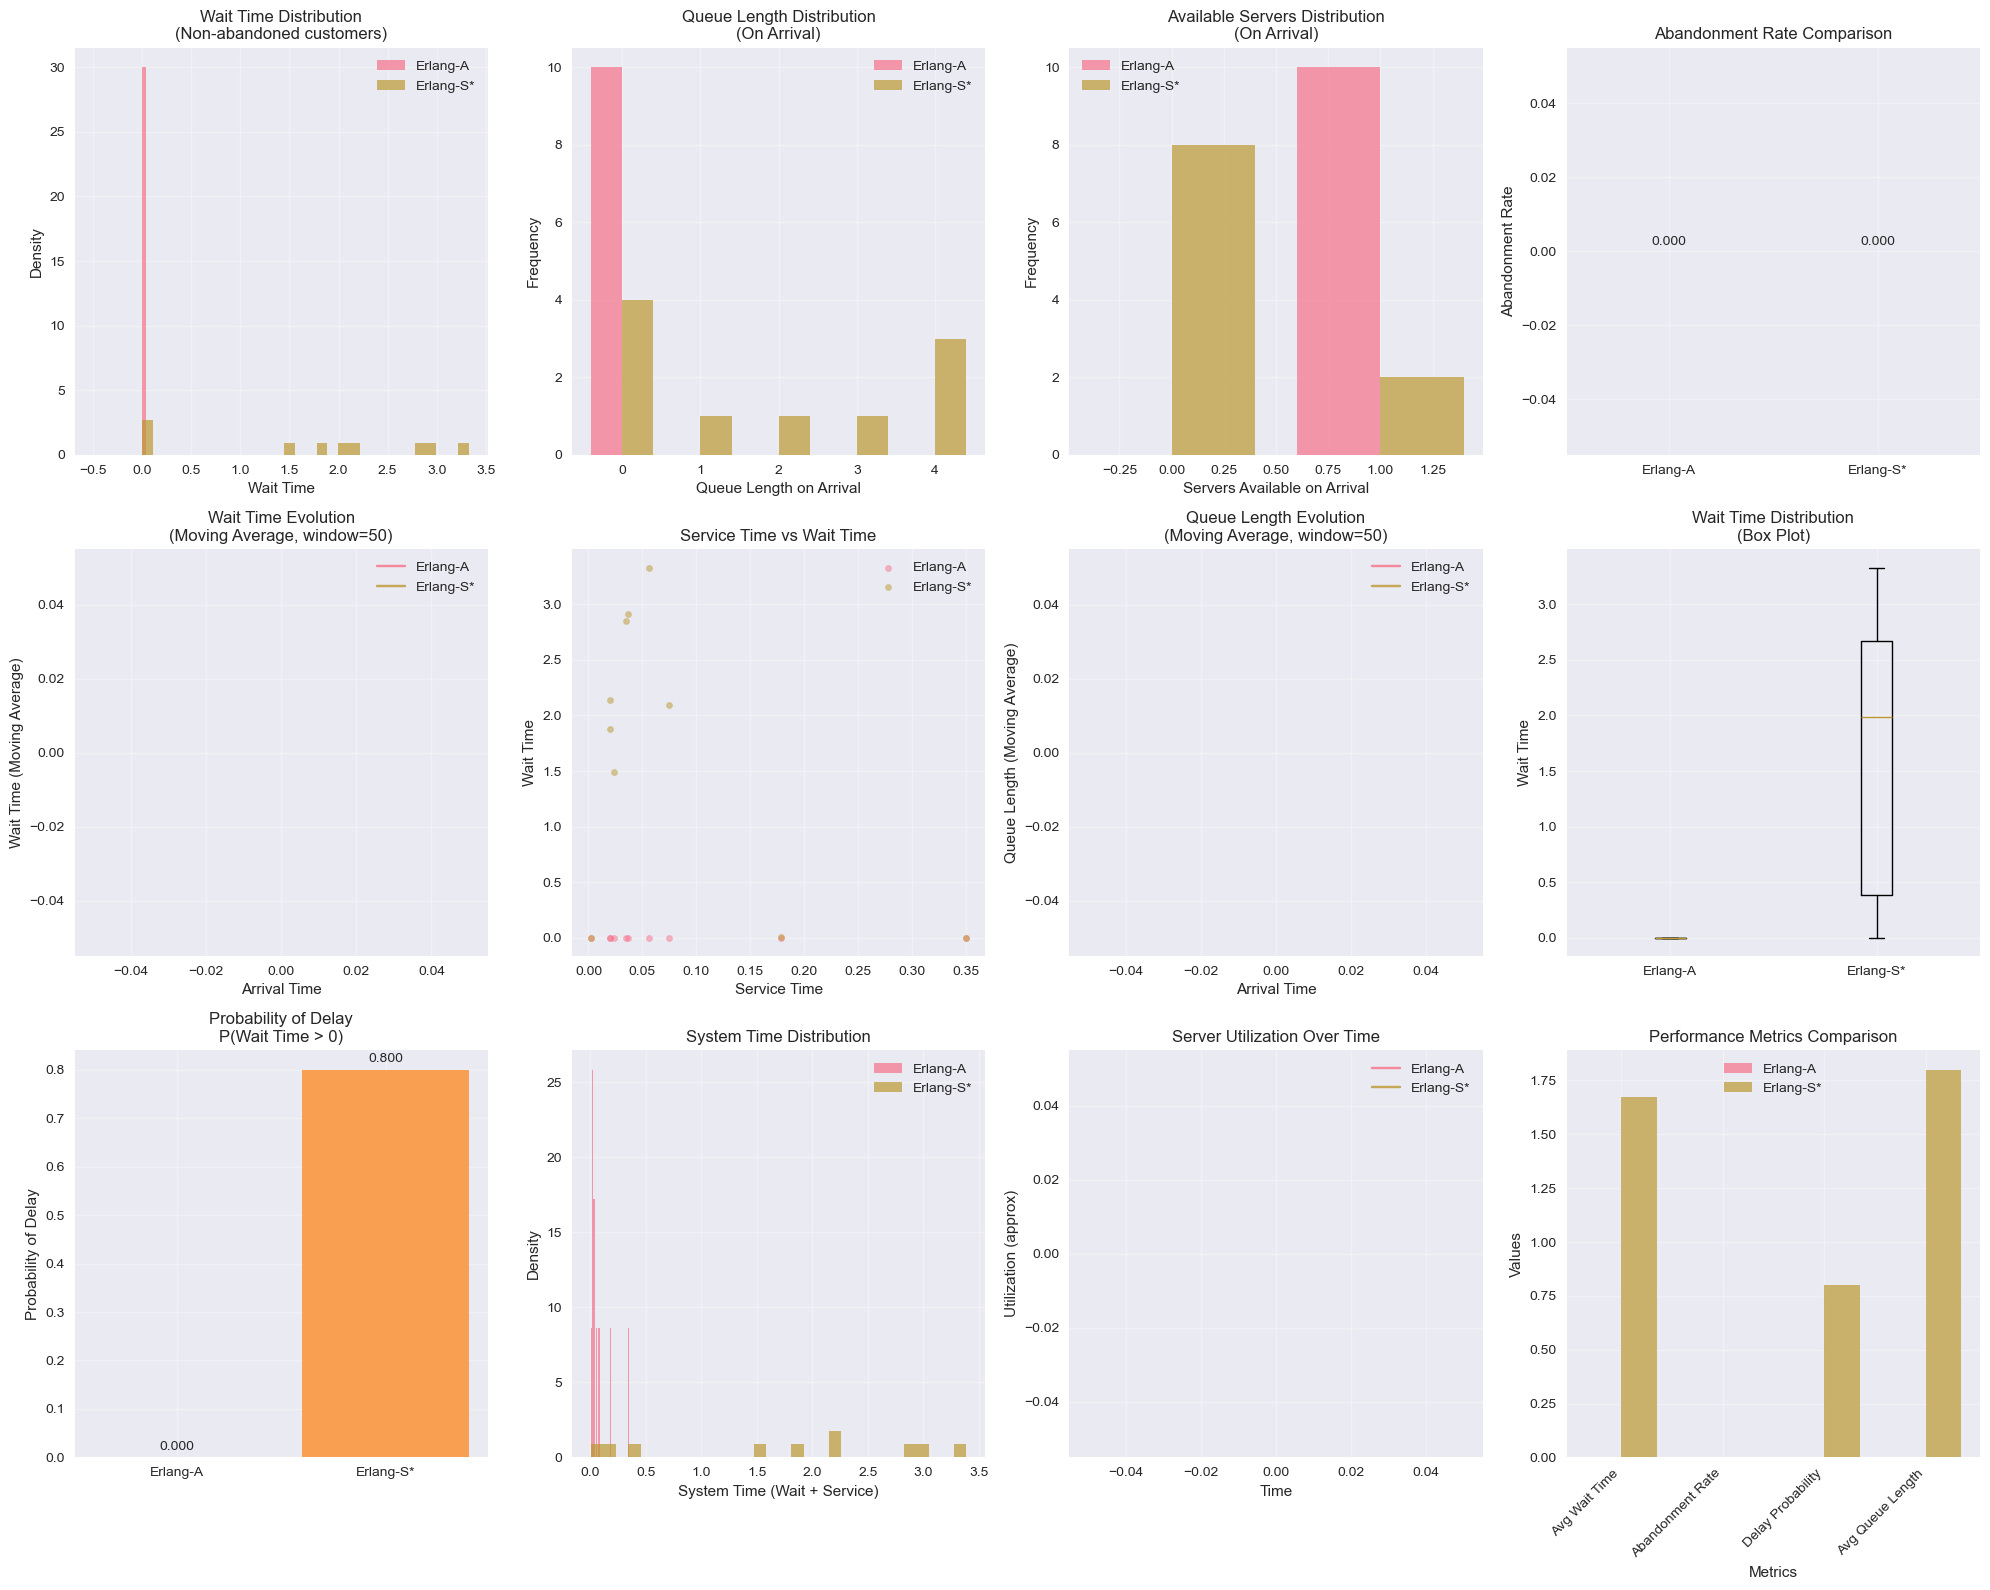


Simulation completed! Check the generated plots for detailed analysis.


In [247]:
if __name__ == "__main__":
    # Simulation parameters
    params = {
        'lambda': 2.0,    # Arrival rate
        'mu': 10.0,        # Service rate  
        'theta': 0.00001,     # Abandonment rate
        'c': 1,           # Number of servers
        'p': 1,         # Probability of going to charge (Erlang-S* only)
        'gamma': 1      # Charging completion rate (Erlang-S* only)
    }
    
    num_customers = 10
    
    print("Starting queue simulations...")
    print(f"Simulating {num_customers} customers with parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Run Erlang-A simulation
    print("\nRunning Erlang-A simulation...")
    sim_a = QueueSimulation(
        num_customers=num_customers,
        lambda_rate=params['lambda'],
        mu_rate=params['mu'],
        theta_rate=params['theta'],
        num_servers=params['c'],
        p_charge=0.0,  # No charging in Erlang-A
        gamma_rate=params['gamma']
    )
    customers_a = sim_a.simulate_erlang_a()
    
    # Run Erlang-S* simulation
    print("Running Erlang-S* simulation...")
    sim_s = QueueSimulation(
        num_customers=num_customers,
        lambda_rate=params['lambda'],
        mu_rate=params['mu'],
        theta_rate=params['theta'],
        num_servers=params['c'],
        p_charge=params['p'],
        gamma_rate=params['gamma']
    )
    customers_s = sim_s.simulate_erlang_s()
    
    # Analyze and visualize results
    print("Analyzing results and creating visualizations...")
    df_results = analyze_and_visualize(customers_a, customers_s, params, save_plots=True)
    
    print("\nSimulation completed! Check the generated plots for detailed analysis.")

In [245]:
for c in customers_s:
    print(c)
#put how many are charging at the time of arrival

Customer(id=0, arrival_time=0.23463404498842955, service_time=0.0020799307999138624, patience_time=94637.08738997986, queue_length_on_arrival=0, servers_available_on_arrival=1, servers_occupied_on_arrival=0, servers_charging_on_arrival=0, system_size_on_arrival=0, wait_time=0.0, service_start_time=0.23463404498842955, departure_time=0.2367139757883434, abandoned=False)
Customer(id=1, arrival_time=1.7396947604471902, service_time=0.3503557475158312, patience_time=15023.452872733864, queue_length_on_arrival=0, servers_available_on_arrival=1, servers_occupied_on_arrival=0, servers_charging_on_arrival=0, system_size_on_arrival=0, wait_time=0.0, service_start_time=1.7396947604471902, departure_time=2.0900505079630216, abandoned=False)
Customer(id=2, arrival_time=2.398067607219915, service_time=0.1786429543354675, patience_time=34551.551200240225, queue_length_on_arrival=0, servers_available_on_arrival=0, servers_occupied_on_arrival=0, servers_charging_on_arrival=1, system_size_on_arrival=0,

In [246]:
# Print detailed results
print_customer_server_details(customers_s, "TEST ERLANG-S*", max_customers=20)

# Run detailed event trace
debug_sim = print_simulation_events(customers_s, params)

debug_customer_charging_states(customers_s)


=== TEST ERLANG-S* DETAILED CUSTOMER SERVER STATES ===
Showing first 10 customers:

ID  Arrival  Queue Available Occupied Charging Total Wait   Abandoned
---------------------------------------------------------------------------
0   0.23     0     1         0        0        1     0.00   False    
1   1.74     0     1         0        0        1     0.00   False    
2   2.40     0     0         0        1        1     0.01   False    
3   2.85     0     0         0        1        1     1.50   False    
4   2.94     1     0         0        1        1     1.88   False    
5   3.02     2     0         0        1        1     2.14   False    
6   3.05     3     0         0        1        1     2.91   False    
7   4.06     4     0         0        1        1     2.10   False    
8   4.52     4     0         0        1        1     3.33   False    
9   5.13     4     0         0        1        1     2.85   False    

Summary for TEST ERLANG-S*:
  Average servers available: 0.20
  Aver

In [206]:
debug_customer_charging_states(customers_s)


=== CUSTOMER CHARGING STATES DEBUG ===
Distribution of servers_charging_on_arrival:
  0 servers charging: 8 customers (80.0%)
  1 servers charging: 2 customers (20.0%)

First few customers with servers charging:
  Customer 1: arrival=0.348, charging=1
  Customer 2: arrival=0.480, charging=1



DETAILED SERVER STATE ANALYSIS

=== ERLANG-A DETAILED CUSTOMER SERVER STATES ===
Showing first 5 customers:

ID  Arrival  Queue Available Occupied Charging Total Wait   Abandoned
---------------------------------------------------------------------------
0   0.05     0     2         0        0        2     0.00   False    
1   0.35     0     2         0        0        2     0.00   False    
2   0.48     0     2         0        0        2     0.00   False    
3   0.57     0     1         1        0        2     0.00   False    
4   0.59     0     0         2        0        2     0.90   False    

Summary for ERLANG-A:
  Average servers available: 1.40
  Average servers occupied:  0.60
  Average servers charging:  0.00
  Total servers: 2

=== ERLANG-S* DETAILED CUSTOMER SERVER STATES ===
Showing first 5 customers:

ID  Arrival  Queue Available Occupied Charging Total Wait   Abandoned
---------------------------------------------------------------------------
0   0.05     0     2     

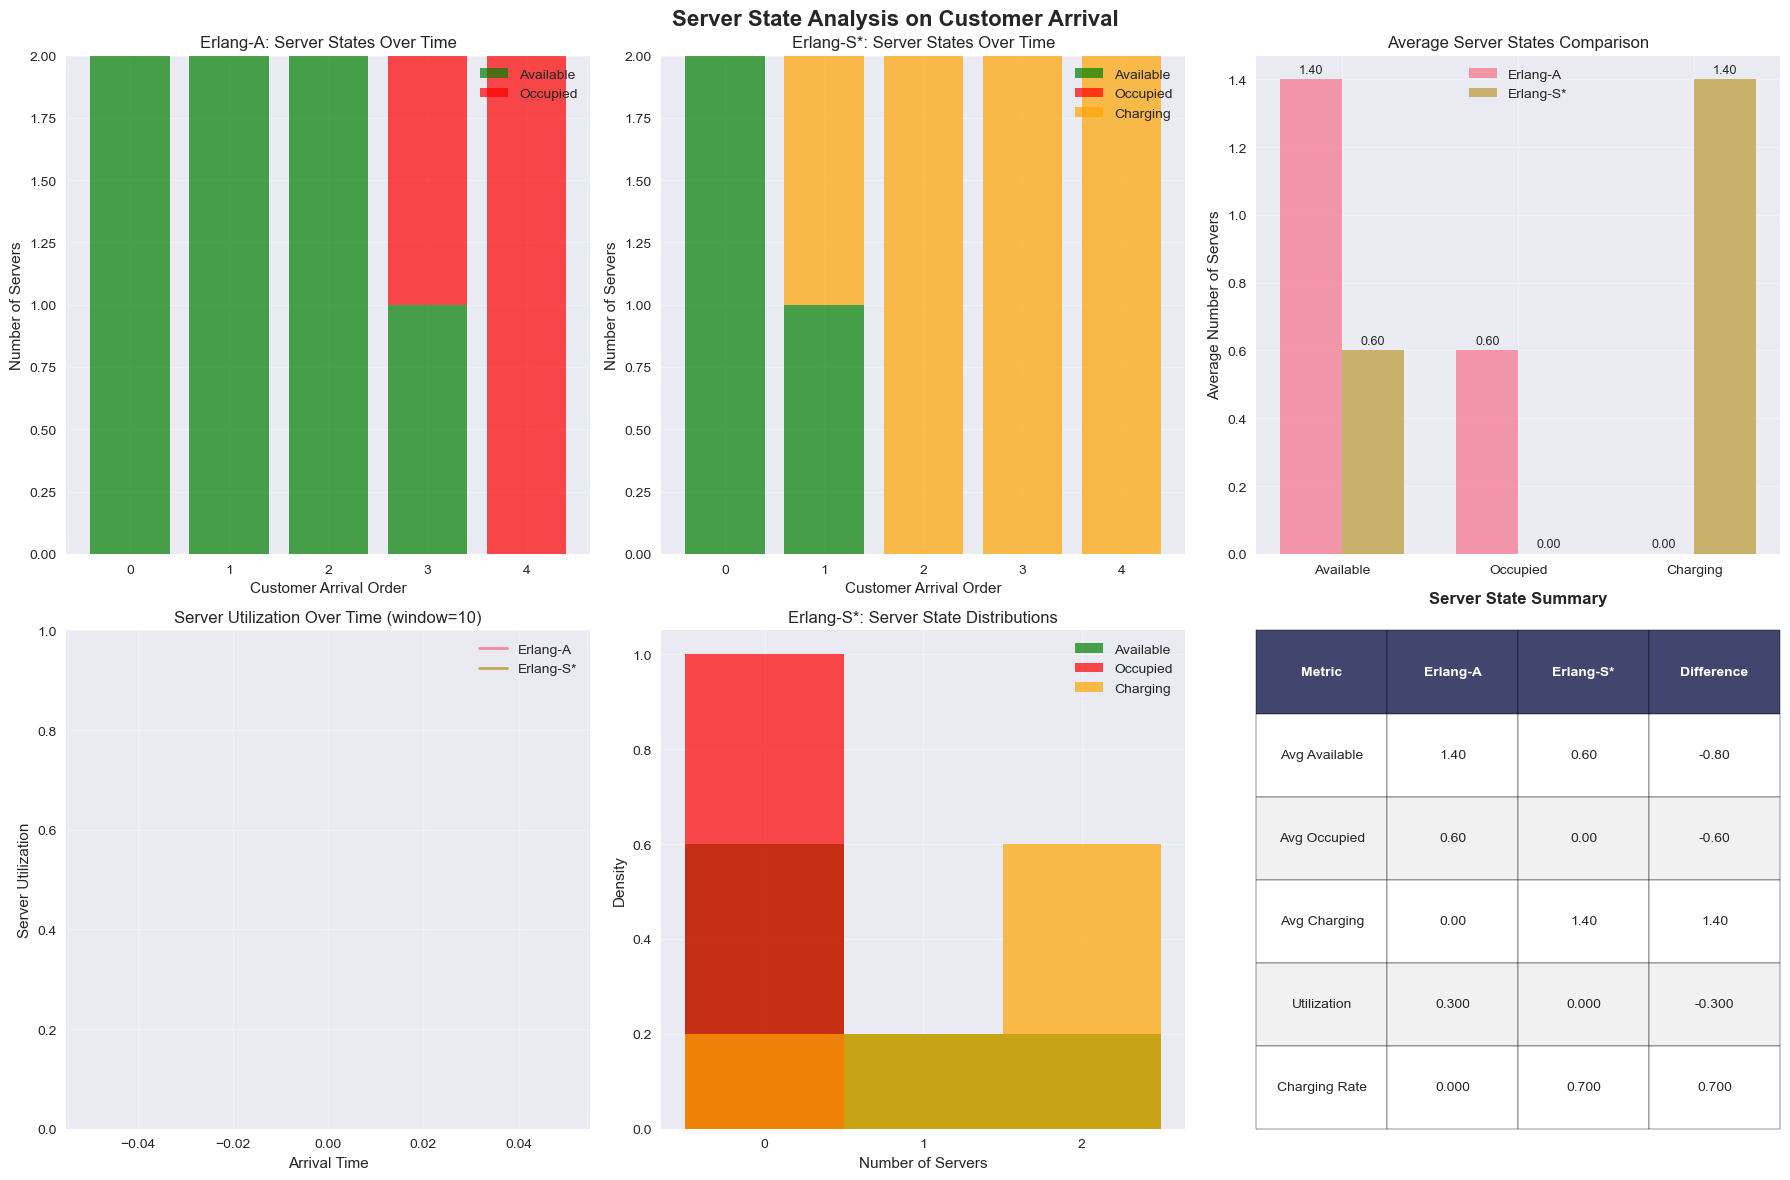


=== SERVER STATE DIAGNOSTICS ===
✅ Charging mechanism appears to be working


In [179]:
# Add this after your existing analysis
print("\n" + "="*60)
print("DETAILED SERVER STATE ANALYSIS")
print("="*60)

# Print detailed customer information
print_customer_server_details(customers_a, "ERLANG-A", max_customers=10)
print_customer_server_details(customers_s, "ERLANG-S*", max_customers=10)

# Create server state analysis
server_analysis = analyze_server_states(customers_a, customers_s, params, save_plot=True)

Creating detailed queue length distribution analysis...


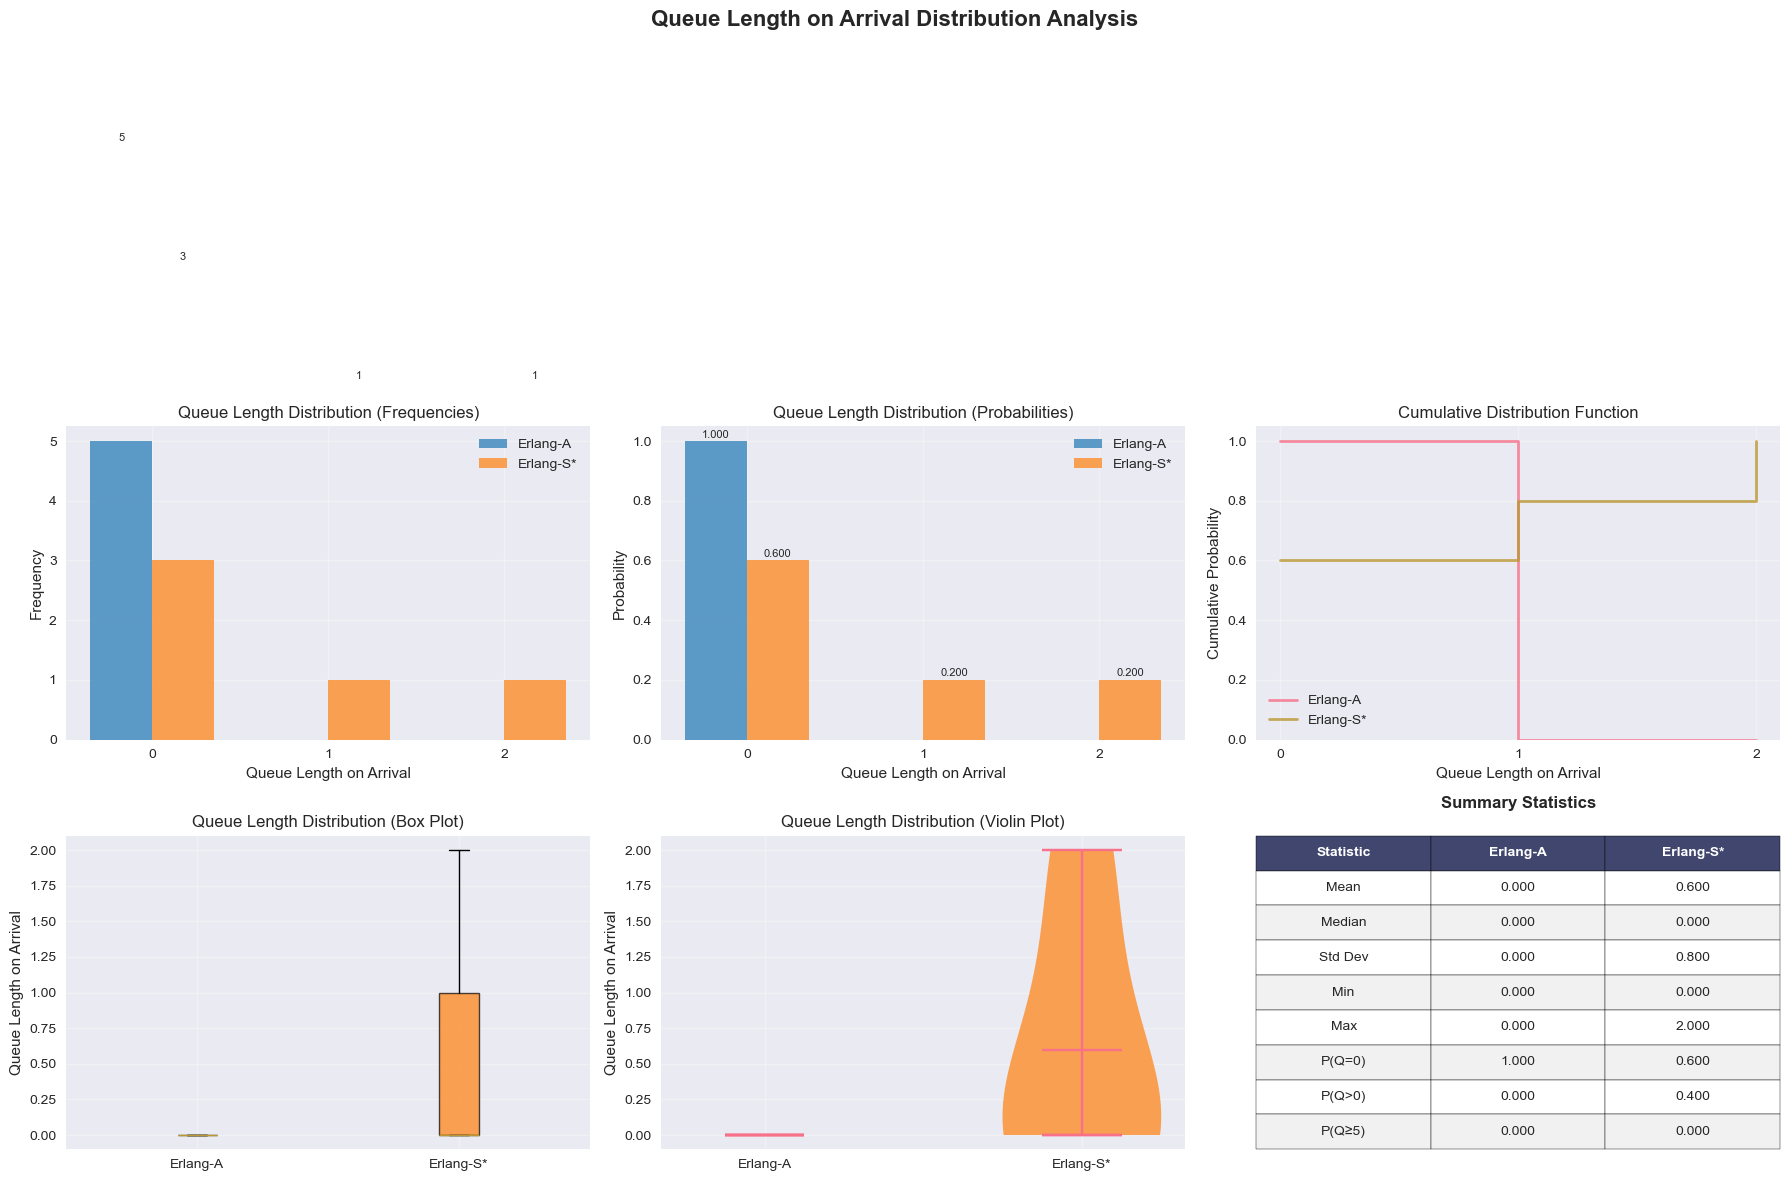


=== QUEUE LENGTH ON ARRIVAL ANALYSIS ===
Parameters: λ=10.0, μ=1.0, θ=1e-05, c=2
Erlang-S* specific: p=1, γ=1

ERLANG-A QUEUE:
  Mean: 0.000
  Median: 0.000
  Std Dev: 0.000
  Min: 0.000
  Max: 0.000
  P(Q=0): 1.000
  P(Q>0): 0.000
  P(Q≥5): 0.000

ERLANG-S* QUEUE:
  Mean: 0.600
  Median: 0.000
  Std Dev: 0.800
  Min: 0.000
  Max: 2.000
  P(Q=0): 0.600
  P(Q>0): 0.400
  P(Q≥5): 0.000

Difference in means: 0.600
Ratio of means (S*/A): inf


/var/folders/hw/c1hvs2r15_l8_lrmw62h0wk00000gn/T/ipykernel_46873/3118058723.py:207: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Ratio of means (S*/A): {stats_s['Mean'] / stats_a['Mean']:.3f}")


In [190]:
# After running both simulations, add this:
print("Creating detailed queue length distribution analysis...")
queue_analysis = plot_queue_length_distribution(customers_a, customers_s, params, save_plot=True)

Creating system size distribution analysis...
DEBUG: max_system=2, mean=0.6, std=0.8
DEBUG: p99.9=2.0, 3σ limit=3, display_max=1


/var/folders/hw/c1hvs2r15_l8_lrmw62h0wk00000gn/T/ipykernel_46873/1024977091.py:123: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax3.text(0.5, 0.5, f'Theoretical mean ({theoretical_mean:.1f}) is\nmuch larger than display range\n(0-{display_max})\n\nCheck simulation parameters!',


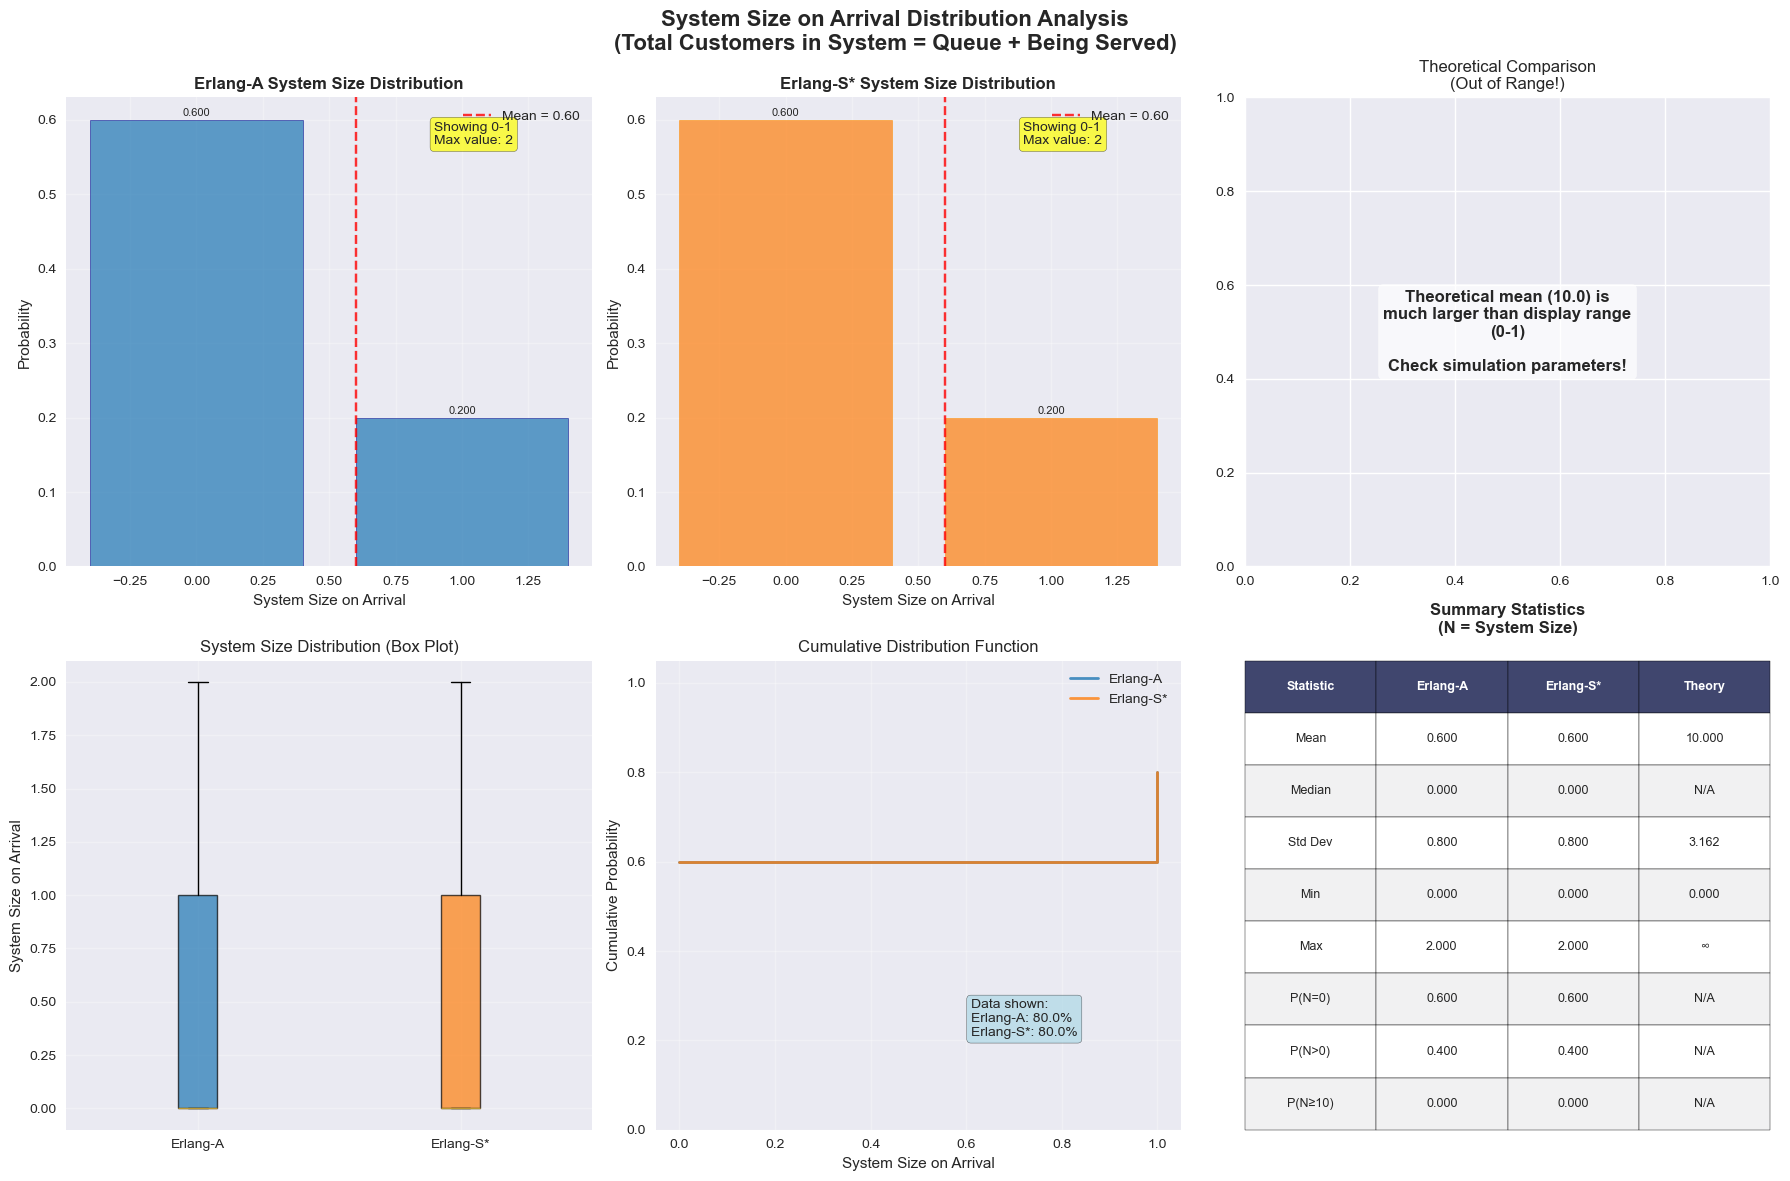


=== SYSTEM SIZE ON ARRIVAL ANALYSIS ===
Parameters: λ=10.0, μ=1.0, θ=1e-05, c=2
Theoretical mean (λ/μ): 10.000
Erlang-S* specific: p=1, γ=1

⚠️  WARNING: Observed mean (0.6) differs significantly from theory (10.0)!
   This suggests either:
   1. Simulation hasn't reached steady state
   2. There's a bug in the simulation
   3. Parameters create an unstable system

ERLANG-A SYSTEM:
  Mean: 0.600
  Median: 0.000
  Std Dev: 0.800
  Min: 0.000
  Max: 2.000
  P(N=0): 0.600
  P(N>0): 0.400
  P(N≥10): 0.000

ERLANG-S* SYSTEM:
  Mean: 0.600
  Median: 0.000
  Std Dev: 0.800
  Min: 0.000
  Max: 2.000
  P(N=0): 0.600
  P(N>0): 0.400
  P(N≥10): 0.000

THEORETICAL (Poisson):
  Mean: 10.000
  Median: N/A
  Std Dev: 3.162
  Min: 0.000
  Max: ∞
  P(N=0): N/A
  P(N>0): N/A
  P(N≥10): N/A

Difference in means: 0.000
Ratio of means (S*/A): 1.000
Theory vs Erlang-A difference: 9.400
Theory vs Erlang-S* difference: 9.400


In [191]:
# After running both simulations, add this:
print("Creating system size distribution analysis...")
system_analysis = plot_system_size_distribution(customers_a, customers_s, params, save_plot=True)

In [107]:
def debug_simulation_state(customers_a, customers_s, params):
    """Debug function to check if simulation is working correctly"""
    
    print("=== SIMULATION DEBUGGING ===")
    
    # Check abandonment rates
    abandon_rate_a = sum(1 for c in customers_a if c.abandoned) / len(customers_a)
    abandon_rate_s = sum(1 for c in customers_s if c.abandoned) / len(customers_s)
    
    print(f"Abandonment rates:")
    print(f"  Erlang-A: {abandon_rate_a:.3f}")
    print(f"  Erlang-S*: {abandon_rate_s:.3f}")
    
    # Check if customers are actually getting served
    served_a = sum(1 for c in customers_a if not c.abandoned)
    served_s = sum(1 for c in customers_s if not c.abandoned)
    
    print(f"Customers served:")
    print(f"  Erlang-A: {served_a} / {len(customers_a)}")
    print(f"  Erlang-S*: {served_s} / {len(customers_s)}")
    
    # Check system size statistics
    system_sizes_a = [c.system_size_on_arrival for c in customers_a]
    system_sizes_s = [c.system_size_on_arrival for c in customers_s]
    
    print(f"System size on arrival:")
    print(f"  Erlang-A: mean={np.mean(system_sizes_a):.1f}, max={max(system_sizes_a)}")
    print(f"  Erlang-S*: mean={np.mean(system_sizes_s):.1f}, max={max(system_sizes_s)}")
    
    # Check if charging is actually happening - we need to estimate this differently
    # Since charging is now per service completion event with probability p, 
    # we can't directly check customer attributes
    print(f"Charging probability (p): {params['p']:.3f}")
    print(f"Expected charging events: {served_s * params['p']:.1f} out of {served_s} service completions")
    print(f"(Note: Charging decisions are made at service completion, not per customer)")
    
    # Traffic intensity check
    rho = params['lambda'] / params['mu']
    print(f"Traffic intensity ρ = λ/μ = {rho:.1f}")
    print(f"Number of servers: {params['c']}")
    
    if rho > params['c']:
        print("⚠️  WARNING: System is OVERLOADED! ρ > c")
        print("   Most customers will abandon - differences between systems may be minimal")
    else:
        print("✅ System appears stable: ρ < c")
    
    # Check theoretical expectations
    theoretical_mean = params['lambda'] / (params['mu'] + params['theta'])
    print(f"Theoretical system size mean (λ/(μ+θ)): {theoretical_mean:.1f}")
    
    # Additional diagnostic info
    print(f"\nAdditional diagnostics:")
    print(f"  Service rate μ: {params['mu']}")
    print(f"  Abandonment rate θ: {params['theta']}")
    print(f"  Charging rate γ: {params['gamma']}")
    print(f"  Effective departure rate: {params['mu'] + params['theta']}")
    
    # Check if the two systems show meaningful differences
    mean_diff = abs(np.mean(system_sizes_s) - np.mean(system_sizes_a))
    abandon_diff = abs(abandon_rate_s - abandon_rate_a)
    
    print(f"\nSystem differences:")
    print(f"  System size difference: {mean_diff:.3f}")
    print(f"  Abandonment rate difference: {abandon_diff:.3f}")
    
    if mean_diff < 0.1 and abandon_diff < 0.01:
        print("⚠️  WARNING: Very small differences between systems!")
        print("   This could indicate:")
        print("   1. System is overloaded (differences masked)")
        print("   2. Charging effect is minimal")
        print("   3. Need larger sample size")
        print("   4. Bug in charging implementation")
    else:
        print("✅ Systems show meaningful differences")
    
    return {
        'abandon_rate_a': abandon_rate_a,
        'abandon_rate_s': abandon_rate_s,
        'system_sizes_a': system_sizes_a,
        'system_sizes_s': system_sizes_s,
        'mean_difference': mean_diff,
        'abandon_difference': abandon_diff
    }

# Run this after your simulations
debug_info = debug_simulation_state(customers_a, customers_s, params)

=== SIMULATION DEBUGGING ===
Abandonment rates:
  Erlang-A: 0.075
  Erlang-S*: 0.124
Customers served:
  Erlang-A: 9253 / 10000
  Erlang-S*: 8763 / 10000
System size on arrival:
  Erlang-A: mean=51.9, max=78
  Erlang-S*: mean=51.7, max=77
Charging probability (p): 0.500
Expected charging events: 4381.5 out of 8763 service completions
(Note: Charging decisions are made at service completion, not per customer)
Traffic intensity ρ = λ/μ = 50.0
Number of servers: 50
✅ System appears stable: ρ < c
Theoretical system size mean (λ/(μ+θ)): 25.0

Additional diagnostics:
  Service rate μ: 1.0
  Abandonment rate θ: 1.0
  Charging rate γ: 0.5
  Effective departure rate: 2.0

System differences:
  System size difference: 0.168
  Abandonment rate difference: 0.049
✅ Systems show meaningful differences


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def build_linear_model(customers_a, customers_s, system_type='both'):
    """Build linear regression model for wait time prediction"""
    
    # Prepare data
    if system_type == 'erlang_a':
        data = customers_a
        system_name = 'Erlang-A'
    elif system_type == 'erlang_s':
        data = customers_s  
        system_name = 'Erlang-S*'
    else:
        data = customers_a + customers_s
        system_name = 'Combined'
    
    # Filter to non-abandoned customers only
    non_abandoned = [c for c in data if not c.abandoned]
    
    if len(non_abandoned) == 0:
        print("No non-abandoned customers found!")
        return None
    
    # Create feature matrix
    features = []
    targets = []
    
    for customer in non_abandoned:
        # Basic features that are known at arrival
        feature_vector = [
            customer.queue_length_on_arrival,
            customer.servers_available_on_arrival, 
            customer.system_size_on_arrival,
            customer.arrival_time,
            customer.service_time,  # Known at arrival in simulation
            customer.patience_time  # Known at arrival in simulation
        ]
        
        features.append(feature_vector)
        targets.append(customer.wait_time)
    
    X = np.array(features)
    y = np.array(targets)
    
    # Feature names for interpretation
    feature_names = [
        'queue_length', 'servers_available', 'system_size', 
        'arrival_time', 'service_time', 'patience_time'
    ]
    
    print(f"\n=== LINEAR REGRESSION MODEL ({system_name}) ===")
    print(f"Dataset: {len(non_abandoned)} non-abandoned customers")
    print(f"Features: {feature_names}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features (important for interpretability)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    
    # Feature importance (coefficients)
    print(f"\nFeature Coefficients (standardized):")
    for name, coef in zip(feature_names, model.coef_):
        print(f"  {name:15s}: {coef:8.4f}")
    print(f"  {'intercept':15s}: {model.intercept_:8.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Linear Model Predictions ({system_name})\nTest R² = {test_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'scaler': scaler, 
        'feature_names': feature_names,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

In [109]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def build_polynomial_model(customers_data, degree=2):
    """Build polynomial regression model"""
    
    # Filter to non-abandoned customers only
    non_abandoned = [c for c in customers_data if not c.abandoned]
    
    if len(non_abandoned) == 0:
        print("No non-abandoned customers found!")
        return None
    
    # Create feature matrix
    features = []
    targets = []
    
    for customer in non_abandoned:
        feature_vector = [
            customer.queue_length_on_arrival,
            customer.servers_available_on_arrival, 
            customer.system_size_on_arrival,
            customer.arrival_time,
            customer.service_time,
            customer.patience_time
        ]
        features.append(feature_vector)
        targets.append(customer.wait_time)
    
    X = np.array(features)
    y = np.array(targets)
    
    feature_names = [
        'queue_length', 'servers_available', 'system_size', 
        'arrival_time', 'service_time', 'patience_time'
    ]
    
    print(f"\n=== POLYNOMIAL REGRESSION MODEL (degree={degree}) ===")
    print(f"Dataset: {len(non_abandoned)} non-abandoned customers")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Create polynomial features pipeline
    poly_model = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    # Fit model
    poly_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = poly_model.predict(X_train)
    y_pred_test = poly_model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    
    # Get number of features after polynomial expansion
    poly_features = poly_model.named_steps['poly']
    n_features = poly_features.fit_transform(X_train[:1]).shape[1]
    print(f"  Features after polynomial expansion: {n_features}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Polynomial Model (degree={degree})\nTest R² = {test_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': poly_model,
        'feature_names': feature_names,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'degree': degree,
        'n_features': n_features
    }

In [110]:
from sklearn.ensemble import RandomForestRegressor

def build_random_forest_model(customers_data):
    """Build Random Forest model with feature importance"""
    
    # Filter to non-abandoned customers only
    non_abandoned = [c for c in customers_data if not c.abandoned]
    
    if len(non_abandoned) == 0:
        print("No non-abandoned customers found!")
        return None
    
    # Create feature matrix
    features = []
    targets = []
    
    for customer in non_abandoned:
        feature_vector = [
            customer.queue_length_on_arrival,
            customer.servers_available_on_arrival, 
            customer.system_size_on_arrival,
            customer.arrival_time,
            customer.service_time,
            customer.patience_time
        ]
        features.append(feature_vector)
        targets.append(customer.wait_time)
    
    X = np.array(features)
    y = np.array(targets)
    
    feature_names = [
        'queue_length', 'servers_available', 'system_size', 
        'arrival_time', 'service_time', 'patience_time'
    ]
    
    print(f"\n=== RANDOM FOREST MODEL ===")
    print(f"Dataset: {len(non_abandoned)} non-abandoned customers")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Build Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    
    # Feature importance
    importance = rf_model.feature_importances_
    print(f"\nFeature Importance:")
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    for name, imp in feature_importance:
        print(f"  {name:15s}: {imp:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Random Forest Predictions\nTest R² = {test_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    names, importances = zip(*feature_importance)
    plt.barh(names, importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Ranking')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': rf_model,
        'feature_names': feature_names,
        'feature_importance': feature_importance,
        'test_r2': test_r2,
        'test_rmse': test_rmse
    }

In [111]:
def compare_all_models(customers_data):
    """Compare all three models side by side"""
    
    print("=== MODEL COMPARISON SUMMARY ===")
    
    # Build all models
    linear_result = build_linear_model([], customers_data, 'erlang_s')
    poly_result = build_polynomial_model(customers_data, degree=2)
    rf_result = build_random_forest_model(customers_data)
    
    if all([linear_result, poly_result, rf_result]):
        # Summary comparison
        print(f"\n=== PERFORMANCE COMPARISON ===")
        print(f"{'Model':<20} {'Test R²':<10} {'Test RMSE':<12}")
        print("-" * 45)
        print(f"{'Linear Regression':<20} {linear_result['test_r2']:<10.4f} {linear_result['test_rmse']:<12.4f}")
        print(f"{'Polynomial (deg=2)':<20} {poly_result['test_r2']:<10.4f} {poly_result['test_rmse']:<12.4f}")
        print(f"{'Random Forest':<20} {rf_result['test_r2']:<10.4f} {rf_result['test_rmse']:<12.4f}")
        
        # Determine best model
        models = [
            ('Linear Regression', linear_result['test_r2']),
            ('Polynomial (deg=2)', poly_result['test_r2']),
            ('Random Forest', rf_result['test_r2'])
        ]
        best_model = max(models, key=lambda x: x[1])
        print(f"\n🏆 Best model: {best_model[0]} (R² = {best_model[1]:.4f})")
        
        return {
            'linear': linear_result,
            'polynomial': poly_result,
            'random_forest': rf_result,
            'best_model': best_model[0]
        }
    else:
        print("❌ One or more models failed to build")
        return None

Building wait time prediction models...
TESTING MODELS ON ERLANG-S* SYSTEM
=== MODEL COMPARISON SUMMARY ===

=== LINEAR REGRESSION MODEL (Erlang-S*) ===
Dataset: 8763 non-abandoned customers
Features: ['queue_length', 'servers_available', 'system_size', 'arrival_time', 'service_time', 'patience_time']

Model Performance:
  Train R²: 0.6770
  Test R²:  0.6785
  Train RMSE: 0.0624
  Test RMSE:  0.0625

Feature Coefficients (standardized):
  queue_length   :   0.0971
  servers_available:  -0.0087
  system_size    :  -0.0106
  arrival_time   :   0.0010
  service_time   :   0.0014
  patience_time  :   0.0047
  intercept      :   0.1305


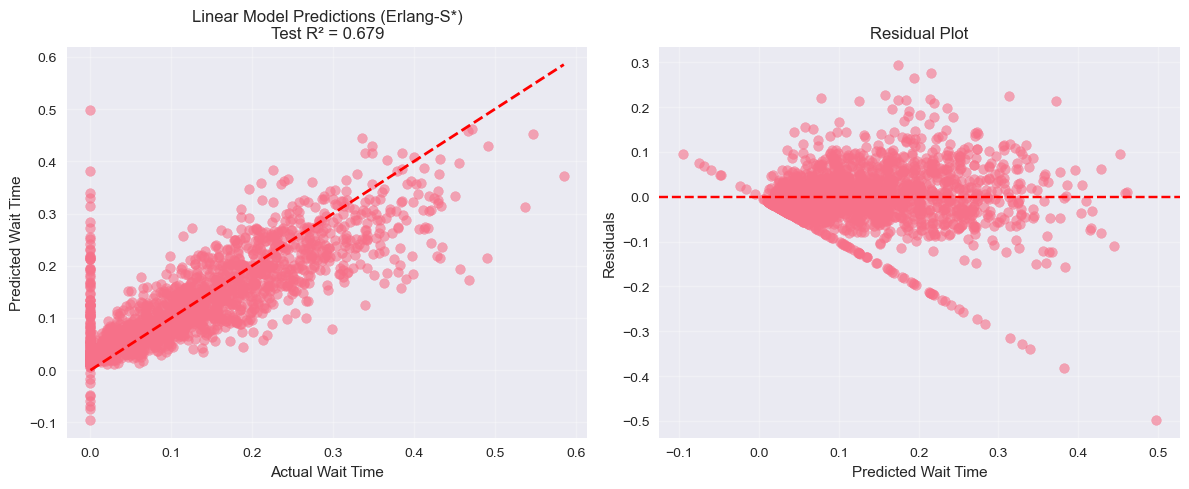


=== POLYNOMIAL REGRESSION MODEL (degree=2) ===
Dataset: 8763 non-abandoned customers

Model Performance:
  Train R²: 0.7833
  Test R²:  0.7958
  Train RMSE: 0.0511
  Test RMSE:  0.0498
  Features after polynomial expansion: 27


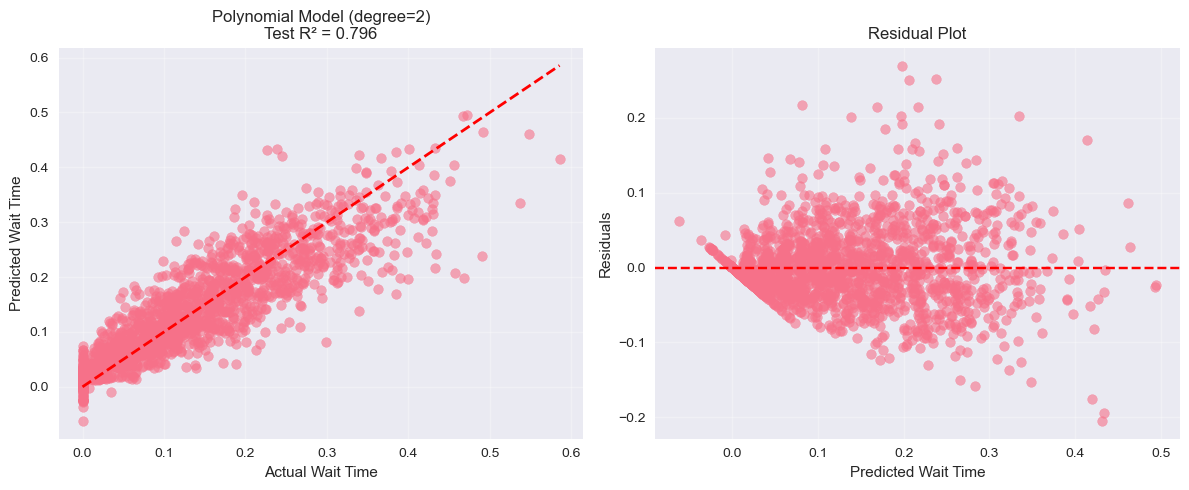


=== RANDOM FOREST MODEL ===
Dataset: 8763 non-abandoned customers

Model Performance:
  Train R²: 0.8763
  Test R²:  0.8264
  Train RMSE: 0.0386
  Test RMSE:  0.0459

Feature Importance:
  queue_length   : 0.7794
  servers_available: 0.1172
  arrival_time   : 0.0413
  patience_time  : 0.0263
  system_size    : 0.0212
  service_time   : 0.0147


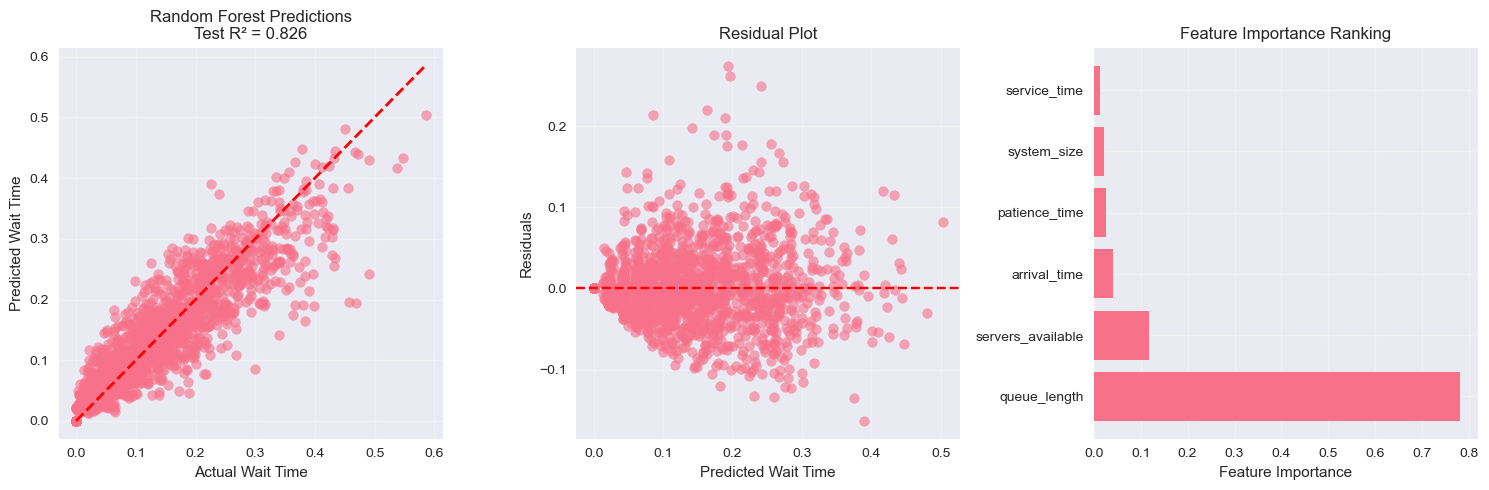


=== PERFORMANCE COMPARISON ===
Model                Test R²    Test RMSE   
---------------------------------------------
Linear Regression    0.6785     0.0625      
Polynomial (deg=2)   0.7958     0.0498      
Random Forest        0.8264     0.0459      

🏆 Best model: Random Forest (R² = 0.8264)


In [112]:
# Updated test cell
print("Building wait time prediction models...")

# Test all models on Erlang-S* system
print("=" * 60)
print("TESTING MODELS ON ERLANG-S* SYSTEM")
print("=" * 60)

model_comparison = compare_all_models(customers_s)

# You can also test individual models:
# linear_model_s = build_linear_model(customers_a, customers_s, 'erlang_s')
# poly_model_s = build_polynomial_model(customers_s, degree=2)  
# rf_model_s = build_random_forest_model(customers_s)

In [115]:
def build_linear_model_with_formula(customers_a, customers_s, system_type='both'):
    """Build linear regression model for wait time prediction with functional form"""
    
    # Prepare data
    if system_type == 'erlang_a':
        data = customers_a
        system_name = 'Erlang-A'
    elif system_type == 'erlang_s':
        data = customers_s  
        system_name = 'Erlang-S*'
    else:
        data = customers_a + customers_s
        system_name = 'Combined'
    
    # Filter to non-abandoned customers only
    non_abandoned = [c for c in data if not c.abandoned]
    
    if len(non_abandoned) == 0:
        print("No non-abandoned customers found!")
        return None
    
    # Create feature matrix
    features = []
    targets = []
    
    for customer in non_abandoned:
        feature_vector = [
            customer.queue_length_on_arrival,
            customer.servers_available_on_arrival, 
            customer.system_size_on_arrival,
            customer.arrival_time,
            customer.service_time,
            customer.patience_time
        ]
        features.append(feature_vector)
        targets.append(customer.wait_time)
    
    X = np.array(features)
    y = np.array(targets)
    
    # Feature names for interpretation
    feature_names = [
        'queue_length', 'servers_available', 'system_size', 
        'arrival_time', 'service_time', 'patience_time'
    ]
    
    print(f"\n=== LINEAR REGRESSION MODEL ({system_name}) ===")
    print(f"Dataset: {len(non_abandoned)} non-abandoned customers")
    print(f"Features: {feature_names}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features (important for interpretability)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    
    # Feature importance (coefficients)
    print(f"\nFeature Coefficients (standardized):")
    for name, coef in zip(feature_names, model.coef_):
        print(f"  {name:15s}: {coef:8.4f}")
    print(f"  {'intercept':15s}: {model.intercept_:8.4f}")
    
    # FUNCTIONAL FORM
    print(f"\n" + "="*50)
    print(f"LINEAR MODEL FUNCTIONAL FORM ({system_name})")
    print(f"="*50)
    
    # Get original scale coefficients
    # For standardized features: X_scaled = (X - mean) / std
    # So: y = intercept + sum(coef_scaled[i] * (X[i] - mean[i]) / std[i])
    # Rearranging: y = (intercept - sum(coef_scaled[i] * mean[i] / std[i])) + sum((coef_scaled[i] / std[i]) * X[i])
    
    means = scaler.mean_
    stds = scaler.scale_
    
    # Calculate original scale coefficients
    original_coefs = model.coef_ / stds
    original_intercept = model.intercept_ - np.sum(model.coef_ * means / stds)
    
    print(f"\nPredicted Wait Time = {original_intercept:.4f}")
    for i, (name, coef) in enumerate(zip(feature_names, original_coefs)):
        sign = "+" if coef >= 0 else ""
        print(f"                    {sign} {coef:.4f} × {name}")
    
    print(f"\nIn mathematical notation:")
    print(f"ŷ = β₀ + β₁×Q + β₂×S + β₃×N + β₄×t + β₅×s + β₆×p")
    print(f"")
    print(f"Where:")
    print(f"  ŷ = Predicted wait time")
    print(f"  Q = Queue length on arrival")
    print(f"  S = Servers available on arrival") 
    print(f"  N = System size on arrival")
    print(f"  t = Arrival time")
    print(f"  s = Service time")
    print(f"  p = Patience time")
    print(f"")
    print(f"Coefficients:")
    print(f"  β₀ = {original_intercept:.4f} (intercept)")
    for i, (name, coef) in enumerate(zip(['Q', 'S', 'N', 't', 's', 'p'], original_coefs)):
        print(f"  β{i+1} = {coef:8.4f} ({feature_names[i]})")
    
    # Interpretation
    print(f"\n" + "="*30)
    print(f"COEFFICIENT INTERPRETATION")
    print(f"="*30)
    
    interpretations = [
        ("Queue length", "Each additional customer in queue increases wait time by"),
        ("Servers available", "Each additional available server decreases wait time by"),
        ("System size", "Each additional customer in system increases wait time by"),
        ("Arrival time", "Each unit increase in arrival time changes wait time by"),
        ("Service time", "Each unit increase in service time changes wait time by"),
        ("Patience time", "Each unit increase in patience time changes wait time by")
    ]
    
    for i, (desc, interp) in enumerate(interpretations):
        coef = original_coefs[i]
        print(f"  {desc}: {interp} {coef:.4f} time units")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Linear Model Predictions ({system_name})\nTest R² = {test_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'scaler': scaler, 
        'feature_names': feature_names,
        'original_coefs': original_coefs,
        'original_intercept': original_intercept,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

def build_polynomial_model_with_formula(customers_data, degree=2):
    """Build polynomial regression model with functional form"""
    
    # Filter to non-abandoned customers only
    non_abandoned = [c for c in customers_data if not c.abandoned]
    
    if len(non_abandoned) == 0:
        print("No non-abandoned customers found!")
        return None
    
    # Create feature matrix
    features = []
    targets = []
    
    for customer in non_abandoned:
        feature_vector = [
            customer.queue_length_on_arrival,
            customer.servers_available_on_arrival, 
            customer.system_size_on_arrival,
            customer.arrival_time,
            customer.service_time,
            customer.patience_time
        ]
        features.append(feature_vector)
        targets.append(customer.wait_time)
    
    X = np.array(features)
    y = np.array(targets)
    
    feature_names = [
        'queue_length', 'servers_available', 'system_size', 
        'arrival_time', 'service_time', 'patience_time'
    ]
    
    print(f"\n=== POLYNOMIAL REGRESSION MODEL (degree={degree}) ===")
    print(f"Dataset: {len(non_abandoned)} non-abandoned customers")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Create polynomial features pipeline
    poly_model = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    # Fit model
    poly_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = poly_model.predict(X_train)
    y_pred_test = poly_model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    
    # Get polynomial feature names
    poly_features = poly_model.named_steps['poly']
    poly_feature_names = poly_features.get_feature_names_out(feature_names)
    n_features = len(poly_feature_names)
    print(f"  Features after polynomial expansion: {n_features}")
    
    # Get coefficients
    linear_model = poly_model.named_steps['linear']
    poly_coefs = linear_model.coef_
    poly_intercept = linear_model.intercept_
    
    # FUNCTIONAL FORM
    print(f"\n" + "="*60)
    print(f"POLYNOMIAL MODEL FUNCTIONAL FORM (degree={degree})")
    print(f"="*60)
    
    print(f"\nPredicted Wait Time = {poly_intercept:.4f}")
    
    # Show top 20 most important polynomial terms
    coef_importance = [(abs(coef), i, name, coef) for i, (coef, name) in enumerate(zip(poly_coefs, poly_feature_names))]
    coef_importance.sort(reverse=True)
    
    print(f"\nTop 20 most important polynomial terms:")
    for rank, (abs_coef, idx, name, coef) in enumerate(coef_importance[:20]):
        sign = "+" if coef >= 0 else ""
        print(f"  {rank+1:2d}. {sign}{coef:8.4f} × {name}")
    
    if degree == 2:
        print(f"\nFor degree=2, the general form includes:")
        print(f"ŷ = β₀ + Σβᵢ×xᵢ + Σβᵢⱼ×xᵢ×xⱼ + Σβᵢᵢ×xᵢ²")
        print(f"")
        print(f"Where:")
        print(f"  Linear terms: Q, S, N, t, s, p")
        print(f"  Interaction terms: Q×S, Q×N, Q×t, Q×s, Q×p, S×N, S×t, etc.")
        print(f"  Quadratic terms: Q², S², N², t², s², p²")
        print(f"")
        print(f"This captures non-linear relationships like:")
        print(f"  - Queue length saturation effects (Q²)")
        print(f"  - Interaction between queue length and available servers (Q×S)")
        print(f"  - Service time dependency on system state (s×N)")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Polynomial Model (degree={degree})\nTest R² = {test_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': poly_model,
        'feature_names': feature_names,
        'poly_feature_names': poly_feature_names,
        'top_terms': coef_importance[:20],
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'degree': degree,
        'n_features': n_features
    }

def build_random_forest_with_interpretation(customers_data):
    """Build Random Forest model with interpretation of ensemble behavior"""
    
    # Filter to non-abandoned customers only
    non_abandoned = [c for c in customers_data if not c.abandoned]
    
    if len(non_abandoned) == 0:
        print("No non-abandoned customers found!")
        return None
    
    # Create feature matrix
    features = []
    targets = []
    
    for customer in non_abandoned:
        feature_vector = [
            customer.queue_length_on_arrival,
            customer.servers_available_on_arrival, 
            customer.system_size_on_arrival,
            customer.arrival_time,
            customer.service_time,
            customer.patience_time
        ]
        features.append(feature_vector)
        targets.append(customer.wait_time)
    
    X = np.array(features)
    y = np.array(targets)
    
    feature_names = [
        'queue_length', 'servers_available', 'system_size', 
        'arrival_time', 'service_time', 'patience_time'
    ]
    
    print(f"\n=== RANDOM FOREST MODEL ===")
    print(f"Dataset: {len(non_abandoned)} non-abandoned customers")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Build Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    
    # Feature importance
    importance = rf_model.feature_importances_
    print(f"\nFeature Importance:")
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    for name, imp in feature_importance:
        print(f"  {name:15s}: {imp:.4f}")
    
    # FUNCTIONAL FORM EXPLANATION
    print(f"\n" + "="*60)
    print(f"RANDOM FOREST FUNCTIONAL FORM")
    print(f"="*60)
    
    print(f"\nRandom Forest creates an ensemble of {rf_model.n_estimators} decision trees.")
    print(f"Each tree learns a piecewise-constant function through recursive splits.")
    print(f"")
    print(f"General form:")
    print(f"ŷ = (1/M) × Σᵢ₌₁ᴹ Tᵢ(Q, S, N, t, s, p)")
    print(f"")
    print(f"Where:")
    print(f"  M = {rf_model.n_estimators} (number of trees)")
    print(f"  Tᵢ = i-th decision tree")
    print(f"  Each tree Tᵢ is a function of the form:")
    print(f"")
    print(f"  Tᵢ(x) = Σⱼ cᵢⱼ × I(x ∈ Rᵢⱼ)")
    print(f"")
    print(f"  Where:")
    print(f"    cᵢⱼ = predicted value in leaf j of tree i")
    print(f"    Rᵢⱼ = rectangular region defined by tree splits")
    print(f"    I(·) = indicator function")
    print(f"")
    print(f"Example tree splits might look like:")
    print(f"  if queue_length ≤ 5:")
    print(f"    if servers_available > 10:")
    print(f"      predict wait_time = 0.1")
    print(f"    else:")
    print(f"      predict wait_time = 2.3")
    print(f"  else:")
    print(f"    if system_size ≤ 20:")
    print(f"      predict wait_time = 5.7")
    print(f"    else:")
    print(f"      predict wait_time = 12.4")
    
    print(f"\nAdvantages of Random Forest:")
    print(f"  ✓ Captures non-linear relationships automatically")
    print(f"  ✓ Handles feature interactions without explicit specification")
    print(f"  ✓ Robust to outliers")
    print(f"  ✓ Provides feature importance rankings")
    print(f"  ✓ No assumptions about data distribution")
    
    print(f"\nModel characteristics:")
    print(f"  Max tree depth: {rf_model.max_depth}")
    print(f"  Min samples per split: {rf_model.min_samples_split}")
    print(f"  Min samples per leaf: {rf_model.min_samples_leaf}")
    
    # Show example prediction path for first few test samples
    print(f"\n" + "="*40)
    print(f"EXAMPLE PREDICTIONS")
    print(f"="*40)
    
    for i in range(min(3, len(X_test))):
        sample = X_test[i]
        prediction = rf_model.predict([sample])[0]
        actual = y_test.iloc[i] if hasattr(y_test, 'iloc') else y_test[i]
        
        print(f"\nSample {i+1}:")
        print(f"  Input features:")
        for j, (name, value) in enumerate(zip(feature_names, sample)):
            print(f"    {name}: {value:.3f}")
        print(f"  Predicted wait time: {prediction:.3f}")
        print(f"  Actual wait time: {actual:.3f}")
        print(f"  Error: {abs(prediction - actual):.3f}")
    
    # Plot feature importance
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Random Forest Predictions\nTest R² = {test_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    names, importances = zip(*feature_importance)
    plt.barh(names, importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Ranking')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': rf_model,
        'feature_names': feature_names,
        'feature_importance': feature_importance,
        'test_r2': test_r2,
        'test_rmse': test_rmse
    }

def compare_all_models_with_formulas(customers_data):
    """Compare all three models with their functional forms"""
    
    print("=" * 80)
    print("MODEL COMPARISON WITH FUNCTIONAL FORMS")
    print("=" * 80)
    
    # Build all models with formulas
    linear_result = build_linear_model_with_formula([], customers_data, 'erlang_s')
    poly_result = build_polynomial_model_with_formula(customers_data, degree=2)
    rf_result = build_random_forest_with_interpretation(customers_data)
    
    if all([linear_result, poly_result, rf_result]):
        # Summary comparison
        print(f"\n" + "="*60)
        print(f"PERFORMANCE AND COMPLEXITY COMPARISON")
        print(f"="*60)
        
        print(f"{'Model':<20} {'Test R²':<10} {'Test RMSE':<12} {'Complexity':<15}")
        print("-" * 65)
        print(f"{'Linear Regression':<20} {linear_result['test_r2']:<10.4f} {linear_result['test_rmse']:<12.4f} {'6 parameters':<15}")
        
        # Fix the problematic line by extracting the value first
        poly_n_features = poly_result["n_features"]
        print(f"{'Polynomial (deg=2)':<20} {poly_result['test_r2']:<10.4f} {poly_result['test_rmse']:<12.4f} {f'{poly_n_features} parameters':<15}")
        
        print(f"{'Random Forest':<20} {rf_result['test_r2']:<10.4f} {rf_result['test_rmse']:<12.4f} {'100 trees':<15}")
        
        # Determine best model
        models = [
            ('Linear Regression', linear_result['test_r2']),
            ('Polynomial (deg=2)', poly_result['test_r2']),
            ('Random Forest', rf_result['test_r2'])
        ]
        best_model = max(models, key=lambda x: x[1])
        print(f"\n🏆 Best model: {best_model[0]} (R² = {best_model[1]:.4f})")
        
        # Model selection guidance
        print(f"\n" + "="*50)
        print(f"MODEL SELECTION GUIDANCE")
        print(f"="*50)
        
        if linear_result['test_r2'] > 0.8:
            print("✅ LINEAR REGRESSION is recommended:")
            print("   • High accuracy (R² > 0.8)")
            print("   • Simple, interpretable form")
            print("   • Fast predictions")
            print("   • Easy to implement in production")
        elif poly_result['test_r2'] - linear_result['test_r2'] > 0.05:
            print("📈 POLYNOMIAL REGRESSION is recommended:")
            print("   • Significant improvement over linear")
            print("   • Captures non-linear relationships")
            print("   • Still relatively interpretable")
        else:
            print("🌲 RANDOM FOREST is recommended:")
            print("   • Best predictive performance")
            print("   • Handles complex interactions")
            print("   • Robust to outliers")
            print("   • Good for black-box predictions")
        
        return {
            'linear': linear_result,
            'polynomial': poly_result,
            'random_forest': rf_result,
            'best_model': best_model[0]
        }
    else:
        print("❌ One or more models failed to build")
        return None

Building wait time prediction models with functional forms...
TESTING MODELS ON ERLANG-S* SYSTEM WITH FUNCTIONAL FORMS
MODEL COMPARISON WITH FUNCTIONAL FORMS

=== LINEAR REGRESSION MODEL (Erlang-S*) ===
Dataset: 8763 non-abandoned customers
Features: ['queue_length', 'servers_available', 'system_size', 'arrival_time', 'service_time', 'patience_time']

Model Performance:
  Train R²: 0.6770
  Test R²:  0.6785
  Train RMSE: 0.0624
  Test RMSE:  0.0625

Feature Coefficients (standardized):
  queue_length   :   0.0971
  servers_available:  -0.0087
  system_size    :  -0.0106
  arrival_time   :   0.0010
  service_time   :   0.0014
  patience_time  :   0.0047
  intercept      :   0.1305

LINEAR MODEL FUNCTIONAL FORM (Erlang-S*)

Predicted Wait Time = 0.0803
                    + 0.0193 × queue_length
                     -0.0036 × servers_available
                     -0.0014 × system_size
                    + 0.0000 × arrival_time
                    + 0.0013 × service_time
               

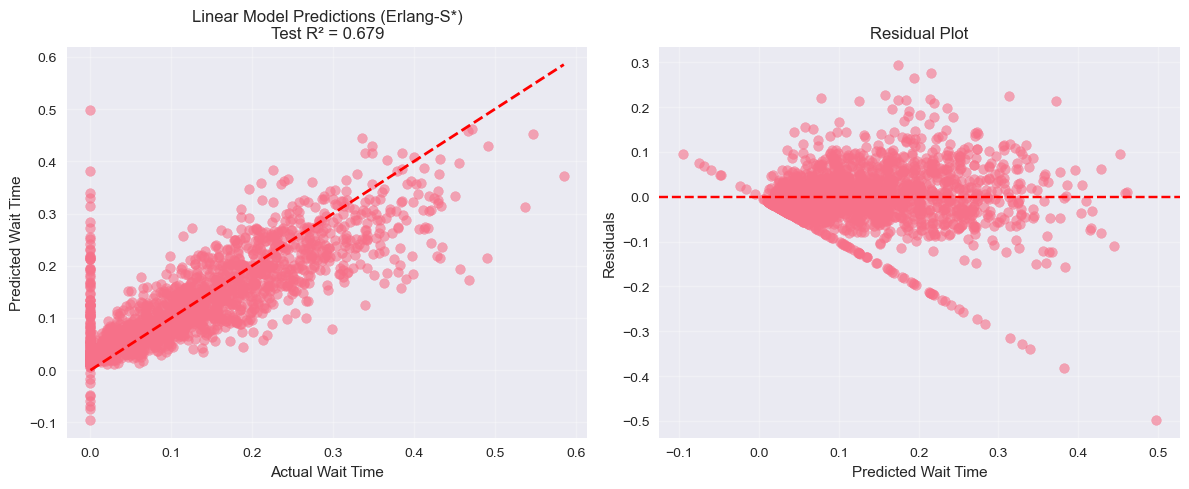


=== POLYNOMIAL REGRESSION MODEL (degree=2) ===
Dataset: 8763 non-abandoned customers

Model Performance:
  Train R²: 0.7833
  Test R²:  0.7958
  Train RMSE: 0.0511
  Test RMSE:  0.0498
  Features after polynomial expansion: 27

POLYNOMIAL MODEL FUNCTIONAL FORM (degree=2)

Predicted Wait Time = 0.1027

Top 20 most important polynomial terms:
   1.  -0.2820 × servers_available
   2.  -0.2187 × queue_length servers_available
   3. +  0.0797 × queue_length
   4.  -0.0192 × queue_length system_size
   5.  -0.0167 × system_size
   6.  -0.0098 × servers_available arrival_time
   7. +  0.0080 × queue_length^2
   8. +  0.0062 × patience_time
   9. +  0.0045 × servers_available system_size
  10.  -0.0043 × queue_length arrival_time
  11. +  0.0040 × queue_length patience_time
  12. +  0.0035 × system_size arrival_time
  13. +  0.0033 × system_size^2
  14.  -0.0026 × system_size patience_time
  15.  -0.0014 × servers_available patience_time
  16. +  0.0012 × servers_available^2
  17.  -0.0012 × 

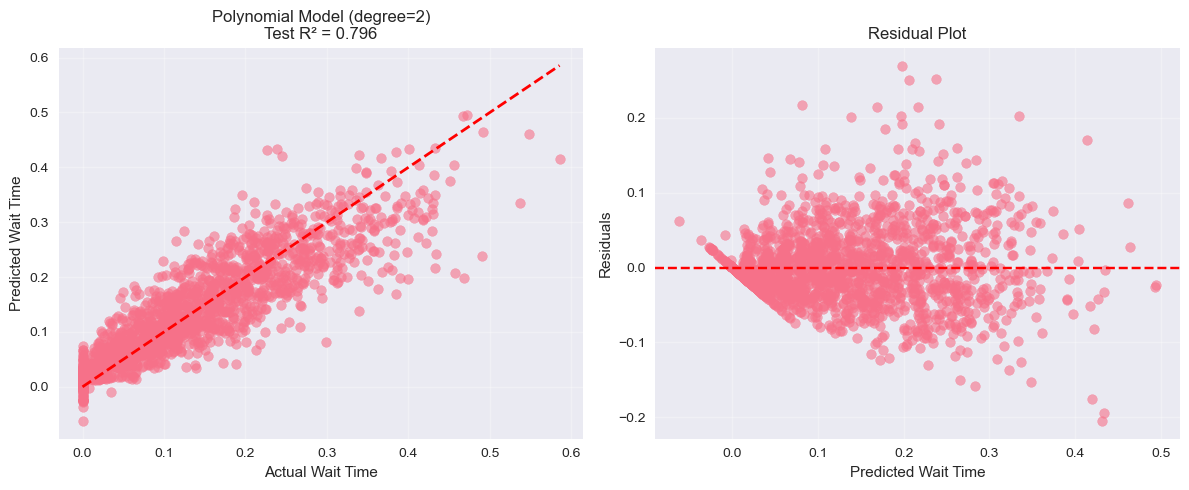


=== RANDOM FOREST MODEL ===
Dataset: 8763 non-abandoned customers

Model Performance:
  Train R²: 0.8763
  Test R²:  0.8264
  Train RMSE: 0.0386
  Test RMSE:  0.0459

Feature Importance:
  queue_length   : 0.7794
  servers_available: 0.1172
  arrival_time   : 0.0413
  patience_time  : 0.0263
  system_size    : 0.0212
  service_time   : 0.0147

RANDOM FOREST FUNCTIONAL FORM

Random Forest creates an ensemble of 100 decision trees.
Each tree learns a piecewise-constant function through recursive splits.

General form:
ŷ = (1/M) × Σᵢ₌₁ᴹ Tᵢ(Q, S, N, t, s, p)

Where:
  M = 100 (number of trees)
  Tᵢ = i-th decision tree
  Each tree Tᵢ is a function of the form:

  Tᵢ(x) = Σⱼ cᵢⱼ × I(x ∈ Rᵢⱼ)

  Where:
    cᵢⱼ = predicted value in leaf j of tree i
    Rᵢⱼ = rectangular region defined by tree splits
    I(·) = indicator function

Example tree splits might look like:
  if queue_length ≤ 5:
    if servers_available > 10:
      predict wait_time = 0.1
    else:
      predict wait_time = 2.3
  e

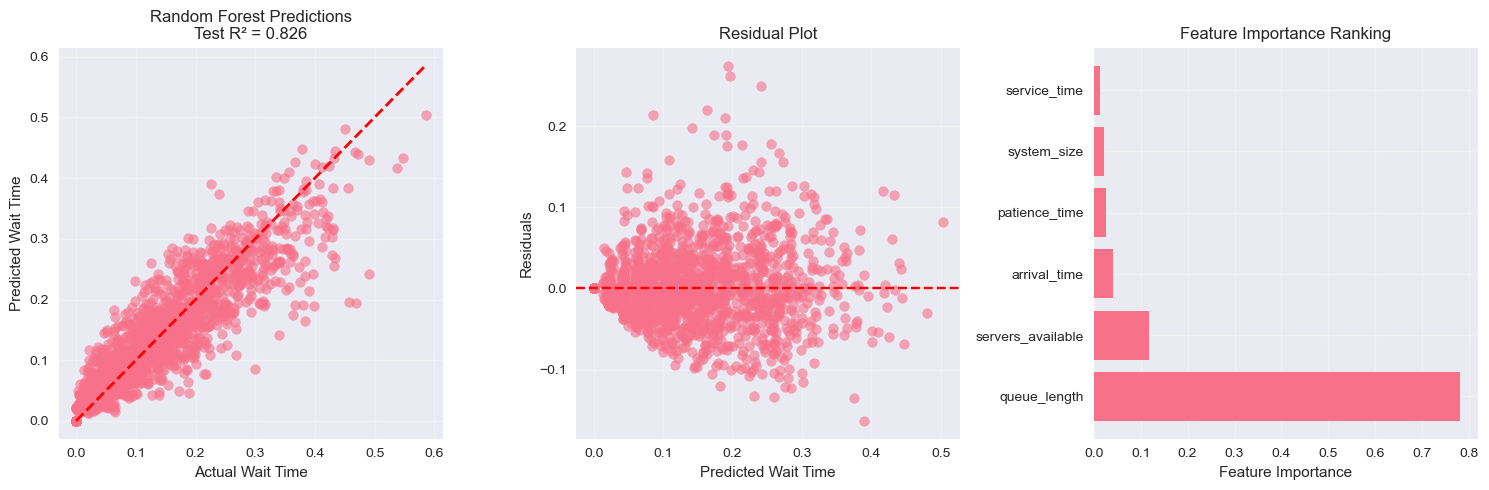


PERFORMANCE AND COMPLEXITY COMPARISON
Model                Test R²    Test RMSE    Complexity     
-----------------------------------------------------------------
Linear Regression    0.6785     0.0625       6 parameters   
Polynomial (deg=2)   0.7958     0.0498       27 parameters  
Random Forest        0.8264     0.0459       100 trees      

🏆 Best model: Random Forest (R² = 0.8264)

MODEL SELECTION GUIDANCE
📈 POLYNOMIAL REGRESSION is recommended:
   • Significant improvement over linear
   • Captures non-linear relationships
   • Still relatively interpretable


In [116]:
# Updated test cell with functional forms
print("Building wait time prediction models with functional forms...")

# Test all models on Erlang-S* system with detailed formulas
print("=" * 80)
print("TESTING MODELS ON ERLANG-S* SYSTEM WITH FUNCTIONAL FORMS")
print("=" * 80)

model_comparison = compare_all_models_with_formulas(customers_s)